In [2]:
import warnings
warnings.filterwarnings('ignore')

#Data preparation and vizsualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

#Label encoding and scaling
from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder

#MinMax Scaler: preserves the shat of the dataset (no distortion), less disruptive to the information in the original data. Does not reduce the importance of outliers.
#Standard Scaler: Use if the data follows a normal distribution, if there is outliers in the data this scaler will scale the data to a small interval. - it's not good with outliers because these affect the mean/variance in a negative way.
#Robust Scaler: Alternative to standard scaler when there are outliers. with this scaler the outliers won't have much of an influence although removing outliers it's always a better option.

#Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

#from sklearn.model_selection import KFold


#Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report,confusion_matrix
from copy import deepcopy

#create a requirements.txt file here and in airflow.
#pip freeze > requirements.txt
#pip install -r requirements.txt

#Move the datasets to the data folder in airflow and read them form there

In [3]:
df_clients = pd.read_csv("dataset.csv", delimiter = ';')

### 1. Data preparation

#### 1.1 Duplicates

In [4]:
#Check for duplicates:
df_clients.duplicated().sum()

0

In [5]:
df_clients.info()
#There are numerical features with object as type. - These columns should be converted before doing any operation.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   object 
 1   mou_Mean          99643 non-null   object 
 2   totmrc_Mean       99643 non-null   object 
 3   da_Mean           99643 non-null   object 
 4   ovrmou_Mean       99643 non-null   object 
 5   ovrrev_Mean       99643 non-null   object 
 6   vceovr_Mean       99643 non-null   object 
 7   datovr_Mean       99643 non-null   object 
 8   roam_Mean         99643 non-null   object 
 9   change_mou        99109 non-null   object 
 10  change_rev        99109 non-null   object 
 11  drop_vce_Mean     100000 non-null  object 
 12  drop_dat_Mean     100000 non-null  object 
 13  blck_vce_Mean     100000 non-null  object 
 14  blck_dat_Mean     100000 non-null  object 
 15  unan_vce_Mean     100000 non-null  object 
 16  unan_dat_Mean     10

#### 1.2 Unbalanced target

In [6]:
#The target column is not unbalanced.
df_clients.groupby('churn')['churn'].count()

churn
0    50438
1    49562
Name: churn, dtype: int64

#### 1.3 NaN values

In [7]:
#We are going to drop the columns with more than 35% of nan values once it will not contribute to the target prediction.

pre_nan = df_clients.isnull().sum().reset_index()
pre_nan = pre_nan.rename(columns={"index": "col_name", 0: "nan_num"})
pre_nan["nan_per"] = (pre_nan.nan_num / df_clients.shape[0]) * 100

df_nan = pre_nan[pre_nan.nan_per > 35]
df_nan

#We are going to remove the following columns: numbcars, HHstatin and dwllsize.

,col_name,nan_num,nan_per
87,numbcars,49366,49.366
88,HHstatin,37923,37.923
89,dwllsize,38308,38.308


In [8]:
#Drpping columns with more than 35% of nan values.
df_clients = df_clients.drop(["numbcars", "HHstatin", "dwllsize"], axis = 1)
# We are left with 96 columns from now on.

#### 1.3.1 Separate variables per type

In [9]:
#Separate the features between, numerical, categorical and target.

numerical_feat = df_clients[['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou', 'change_rev', 'drop_vce_Mean', 'drop_dat_Mean',
                             'blck_vce_Mean', 'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean', 'comp_dat_Mean', 'custcare_Mean',
                             'ccrndmou_Mean', 'cc_mou_Mean', 'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean', 'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean', 'iwylis_vce_Mean', 
                             'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean',
                             'complete_Mean', 'callfwdv_Mean', 'callwait_Mean', 'uniqsubs', 'actvsubs', 'months', 'totcalls', 'totmou', 'totrev', 'adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou', 'avgqty', 'avg3mou',
                             'avg3qty', 'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev', 'hnd_price', 'phones', 'models', 'lor', 'adults', 'income', 'eqpdays']]

categorical_feat = df_clients[['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area', 'dualband', 'refurb_new',  'hnd_webcap', 'truck', 'rv', 'ownrent', 'dwlltype', 'marital', 'infobase', 'forgntvl', 
                               'ethnic', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd']]

target = df_clients.churn

#### 1.3.2 Replacing the nan values in the numerical variables

In [10]:
numerical_feat.head(10)
#Let's start by replacing the commas by dots.

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,avg6mou,avg6qty,avg6rev,hnd_price,phones,models,lor,adults,income,eqpdays
0,"23,9975","219,25","22,5","0,2475",0,0,0,0,0,"-157,25",...,322.0,136.0,38.0,"149,9899902",2.0,2.0,15.0,1.0,4.0,361.0
1,"57,4925","482,75","37,425","0,2475","22,75","9,1","9,1",0,0,"532,25",...,477.0,275.0,48.0,NaN,7.0,6.0,1.0,1.0,5.0,240.0
2,"16,99","10,25","16,99",0,0,0,0,0,0,"-4,25",...,11.0,6.0,17.0,"29,98999023",2.0,1.0,7.0,2.0,5.0,1504.0
3,38,"7,5",38,0,0,0,0,0,0,"-1,5",...,50.0,25.0,40.0,"29,98999023",1.0,1.0,6.0,4.0,6.0,1812.0
4,"55,23","570,5","71,98",0,0,0,0,0,0,"38,5",...,586.0,196.0,80.0,"149,9899902",6.0,4.0,5.0,1.0,6.0,434.0
5,"82,275","1312,25",75,"1,2375",0,0,0,0,0,"156,75",...,1187.0,853.0,78.0,"129,9899902",9.0,4.0,1.0,1.0,6.0,458.0
6,"17,145",0,"16,99",0,0,0,0,0,0,0,...,0.0,0.0,17.0,"29,98999023",4.0,3.0,8.0,3.0,9.0,852.0
7,"38,0525","682,5","52,49","0,2475",0,0,0,0,0,"147,5",...,719.0,112.0,58.0,"79,98999023",3.0,2.0,0.0,2.0,1.0,231.0
8,"97,3375",1039,50,"4,95","419,5","41,95","41,95",0,0,198,...,915.0,434.0,90.0,"29,98999023",3.0,3.0,3.0,3.0,4.0,700.0
9,"31,6625","25,5","29,99","0,2475",0,0,0,0,0,"59,5",...,54.0,7.0,34.0,"79,98999023",2.0,2.0,8.0,2.0,9.0,601.0


In [11]:
#Transform all columns into object type
numerical_feat_object = numerical_feat.astype(str)

#Replace the commas with dots
numerical_feat_prep = numerical_feat_object.apply(lambda x: x.str.replace(',','.'))

#Replace all nan string with nan type
numerical_feat_prep = numerical_feat_prep.replace('nan',np.nan)

#Re-transform all columns back to numerical type
numerical_feat = numerical_feat_prep.apply(pd.to_numeric, errors = 'raise')

#numerical_feat.info()

In [12]:
#Replace all nan values with the respective means.
numerical_feat_final = numerical_feat.fillna(numerical_feat.mean())
#numerical_feat_final.isnull().sum()

#### 1.3.3 Replacing the nan values in the categorical variables

In [13]:
#Arrange categorical variables.
categorical_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   new_cell          100000 non-null  object 
 1   crclscod          100000 non-null  object 
 2   asl_flag          100000 non-null  object 
 3   prizm_social_one  92612 non-null   object 
 4   area              99960 non-null   object 
 5   dualband          99999 non-null   object 
 6   refurb_new        99999 non-null   object 
 7   hnd_webcap        89811 non-null   object 
 8   truck             98268 non-null   float64
 9   rv                98268 non-null   float64
 10  ownrent           66294 non-null   object 
 11  dwlltype          68091 non-null   object 
 12  marital           98268 non-null   object 
 13  infobase          77921 non-null   object 
 14  forgntvl          98268 non-null   float64
 15  ethnic            98268 non-null   object 
 16  kid0_2            982

In [14]:
#Fill nan values with mode.
fill_mode = lambda col: col.fillna(col.mode()[0])

#It will go like this:
#First we replace the area colum with the mode.
categorical_feat.area = categorical_feat.area.fillna(categorical_feat.area.mode()[0])

#Then, we replace the columns which the mode differs by area. These are: prizm_social_one, marital, ethnic and dwlltype
#Here the code line I used to figure this out:
#test = categorical_feat.groupby("area").agg(pd.Series.mode).reset_index()
#test.tail(20)

categorical_feat.prizm_social_one = categorical_feat.groupby(['area'], sort = False)['prizm_social_one'].apply(fill_mode)
categorical_feat.marital = categorical_feat.groupby(['area'], sort = False)['marital'].apply(fill_mode)
categorical_feat.ethnic = categorical_feat.groupby(['area'], sort = False)['ethnic'].apply(fill_mode)
categorical_feat.dwlltype = categorical_feat.groupby(['area'], sort = False)['dwlltype'].apply(fill_mode)

#Lastly, we fill the remaining nan values with the mode without considering the grouped data by area.
categorical_feat_prep = categorical_feat.apply(fill_mode, axis = 0)
categorical_feat_prep.head(10)
#categorical_feat_prep.isnull().sum()

,new_cell,crclscod,asl_flag,prizm_social_one,area,dualband,refurb_new,hnd_webcap,truck,rv,...,marital,infobase,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd
0,U,A,N,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,WCMB,0.0,0.0,...,S,M,0.0,N,U,U,U,U,U,Y
1,N,EA,N,U,CHICAGO AREA,N,N,WC,1.0,1.0,...,S,M,0.0,Z,U,U,U,U,U,Y
2,Y,C,N,S,GREAT LAKES AREA,N,N,WCMB,0.0,0.0,...,M,M,0.0,N,U,Y,U,U,U,Y
3,Y,B,N,T,CHICAGO AREA,N,N,WCMB,0.0,0.0,...,M,M,0.0,U,Y,U,U,U,U,Y
4,Y,A,N,U,NEW ENGLAND AREA,Y,N,WCMB,0.0,0.0,...,S,M,0.0,I,U,U,U,U,U,Y
5,Y,C,N,U,GREAT LAKES AREA,N,N,WCMB,0.0,0.0,...,S,M,0.0,U,U,U,U,U,U,Y
6,N,A,N,C,DALLAS AREA,Y,N,WCMB,0.0,0.0,...,M,M,0.0,N,U,U,U,U,U,Y
7,Y,B,N,S,DALLAS AREA,Y,N,WCMB,0.0,0.0,...,M,M,1.0,S,U,U,U,U,U,Y
8,Y,B,N,S,CHICAGO AREA,Y,N,WCMB,0.0,0.0,...,M,M,0.0,F,U,U,U,U,U,N
9,N,A,N,C,DALLAS AREA,Y,N,WCMB,0.0,0.0,...,M,M,1.0,N,U,U,U,U,U,Y


### 2. Reduce Variables

In [15]:
#Let's now reduce the 5 kids variables into one.
#We are going to create a single column that it has value Y if the household has kids or N if it does not have kids.
#We are also going to assume that if it's U (unknown) than it has not kids (N).

categorical_feat_prep['kids_in_household'] = np.where((categorical_feat_prep.kid0_2 == "Y") | 
                                                      (categorical_feat_prep.kid3_5 == "Y") | 
                                                      (categorical_feat_prep.kid6_10 == "Y") | 
                                                      (categorical_feat_prep.kid11_15 == "Y") | 
                                                      (categorical_feat_prep.kid16_17 == "Y"), "Y", "N")

#Drop unnecessary kids columns.
categorical_feat_final = categorical_feat_prep.drop(['kid0_2','kid3_5', 'kid6_10', 'kid11_15', 'kid16_17'], axis = 1)
#From now on, we have 18 categorical variables.
#categorical_feat_final.shape

#### 2.1 Outliers

In [16]:
#Check the outliers for the numerical variables.
numerical_feat_final.describe()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,avg6mou,avg6qty,avg6rev,hnd_price,phones,models,lor,adults,income,eqpdays
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,58.719985,513.559937,46.179136,0.888828,41.072247,13.559560,13.295062,0.261318,1.286405,-13.933818,...,509.634576,178.365157,58.683618,101.875763,1.787118,1.545825,6.177238,2.530326,5.783112,391.932309
std,46.208972,524.229868,23.581283,2.173729,97.122320,30.446392,30.002391,3.120946,14.685090,274.854774,...,489.562483,180.112088,40.175838,60.746760,1.313971,0.898391,3.956420,1.274685,1.884277,256.480910
min,-6.167500,0.000000,-26.915000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3875.000000,...,0.000000,0.000000,-2.000000,9.989998,1.000000,1.000000,0.000000,1.000000,1.000000,-5.000000
25%,33.311875,151.500000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-86.000000,...,168.000000,61.000000,35.000000,29.989990,1.000000,1.000000,3.000000,2.000000,5.000000,212.000000
50%,48.377500,357.500000,44.990000,0.247500,3.000000,1.050000,0.700000,0.000000,0.000000,-7.000000,...,377.000000,132.000000,50.000000,99.989990,1.000000,1.000000,6.177238,2.530326,5.783112,342.000000
75%,70.630000,701.250000,59.990000,0.888828,42.000000,14.350000,13.950000,0.000000,0.257500,61.750000,...,683.000000,232.000000,70.000000,149.989990,2.000000,2.000000,7.000000,3.000000,7.000000,530.000000
max,3843.262500,12206.750000,409.990000,159.390000,4320.750000,1102.400000,896.087500,423.540000,3685.200000,31219.250000,...,7217.000000,3256.000000,866.000000,499.989990,28.000000,16.000000,15.000000,6.000000,9.000000,1823.000000


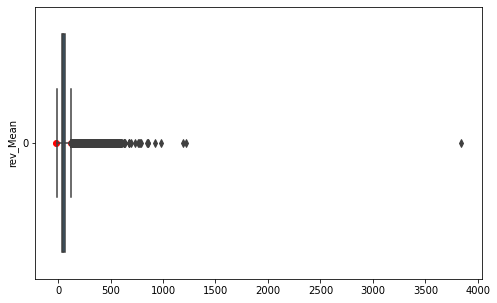

Lower limit of rev_Mean is -23.0
Upper limit of rev_Mean is 127.0


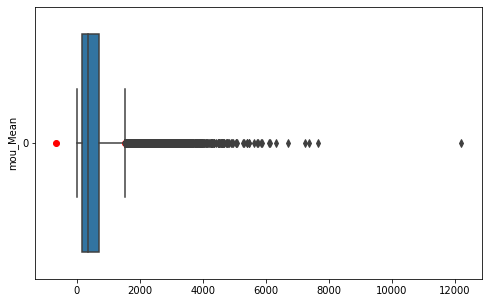

Lower limit of mou_Mean is -673.0
Upper limit of mou_Mean is 1526.0


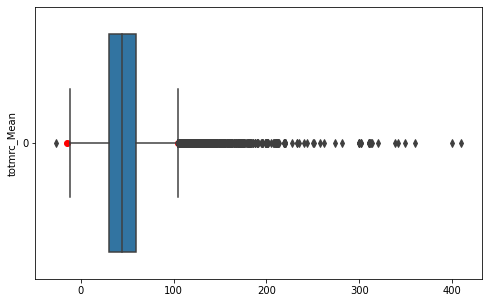

Lower limit of totmrc_Mean is -15.0
Upper limit of totmrc_Mean is 105.0


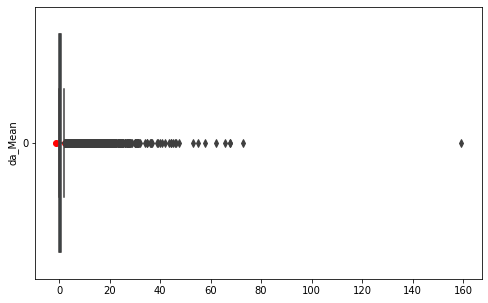

Lower limit of da_Mean is -1.0
Upper limit of da_Mean is 2.0


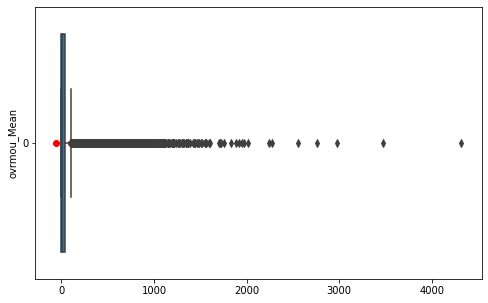

Lower limit of ovrmou_Mean is -63.0
Upper limit of ovrmou_Mean is 105.0


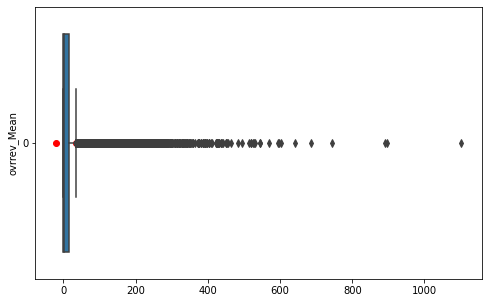

Lower limit of ovrrev_Mean is -22.0
Upper limit of ovrrev_Mean is 36.0


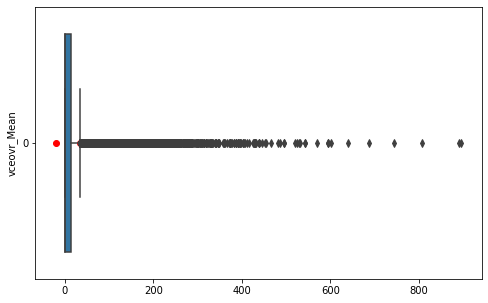

Lower limit of vceovr_Mean is -21.0
Upper limit of vceovr_Mean is 35.0


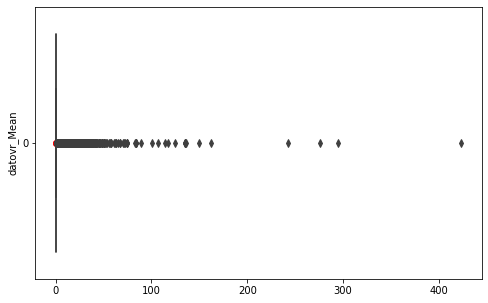

Lower limit of datovr_Mean is 0.0
Upper limit of datovr_Mean is 0.0


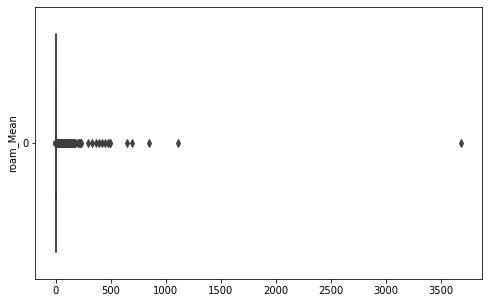

Lower limit of roam_Mean is -0.0
Upper limit of roam_Mean is 1.0


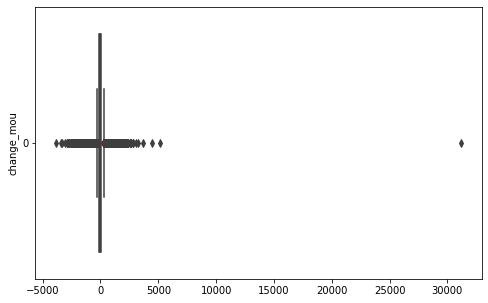

Lower limit of change_mou is -308.0
Upper limit of change_mou is 283.0


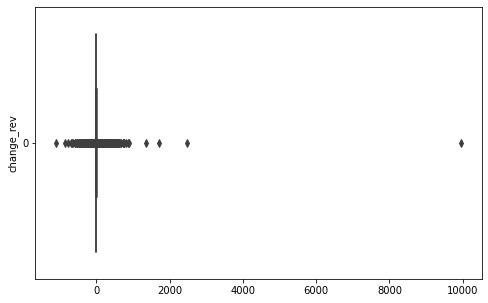

Lower limit of change_rev is -20.0
Upper limit of change_rev is 15.0


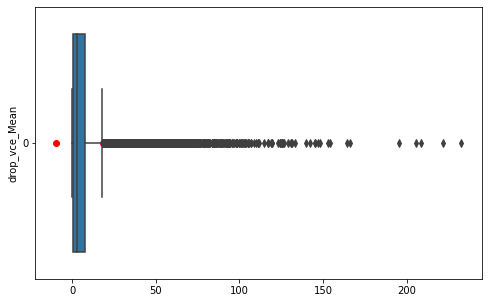

Lower limit of drop_vce_Mean is -10.0
Upper limit of drop_vce_Mean is 18.0


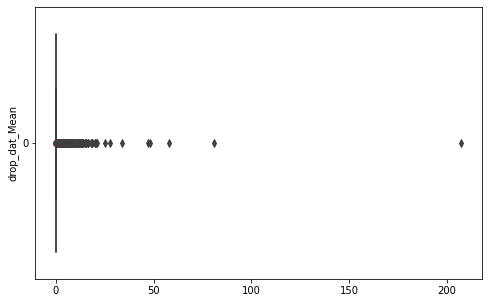

Lower limit of drop_dat_Mean is 0.0
Upper limit of drop_dat_Mean is 0.0


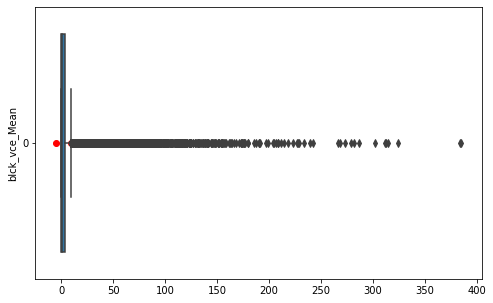

Lower limit of blck_vce_Mean is -6.0
Upper limit of blck_vce_Mean is 9.0


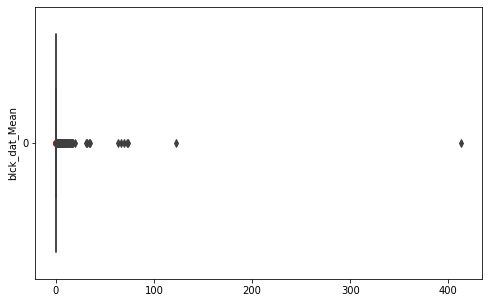

Lower limit of blck_dat_Mean is 0.0
Upper limit of blck_dat_Mean is 0.0


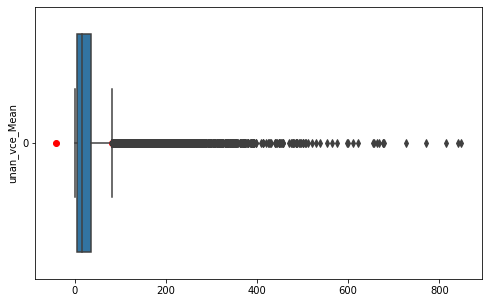

Lower limit of unan_vce_Mean is -42.0
Upper limit of unan_vce_Mean is 82.0


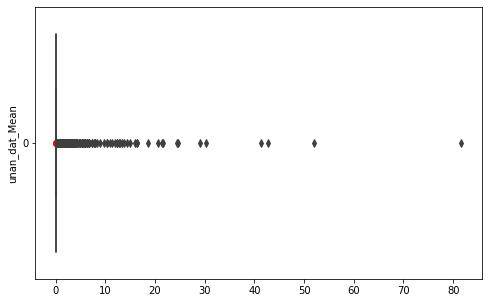

Lower limit of unan_dat_Mean is 0.0
Upper limit of unan_dat_Mean is 0.0


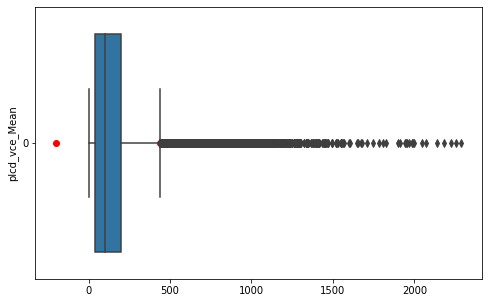

Lower limit of plcd_vce_Mean is -202.0
Upper limit of plcd_vce_Mean is 439.0


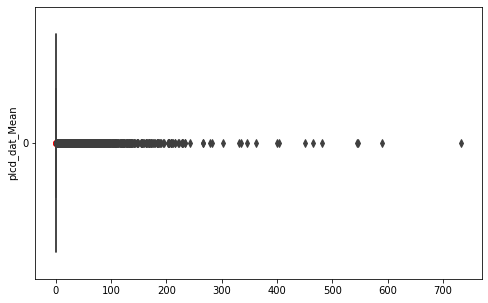

Lower limit of plcd_dat_Mean is 0.0
Upper limit of plcd_dat_Mean is 0.0


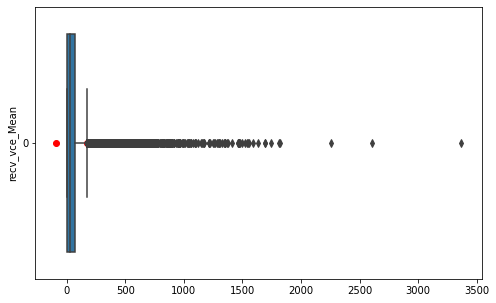

Lower limit of recv_vce_Mean is -94.0
Upper limit of recv_vce_Mean is 170.0


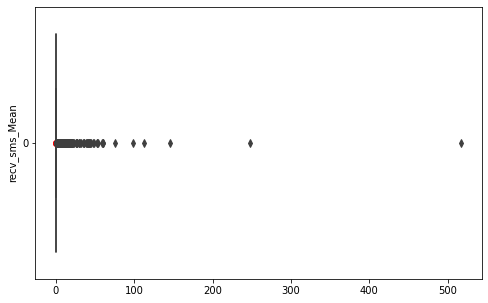

Lower limit of recv_sms_Mean is 0.0
Upper limit of recv_sms_Mean is 0.0


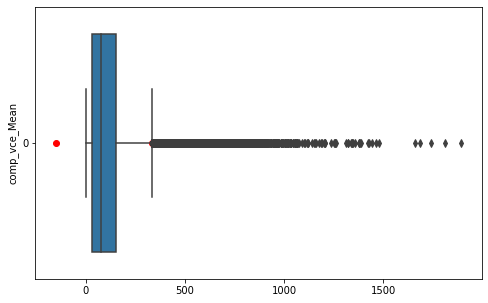

Lower limit of comp_vce_Mean is -153.0
Upper limit of comp_vce_Mean is 331.0


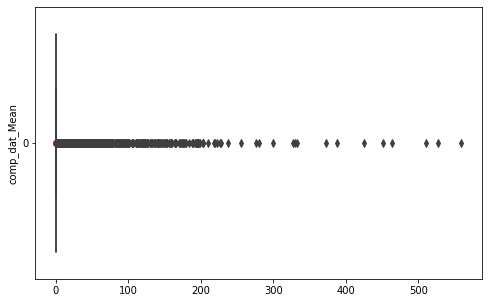

Lower limit of comp_dat_Mean is 0.0
Upper limit of comp_dat_Mean is 0.0


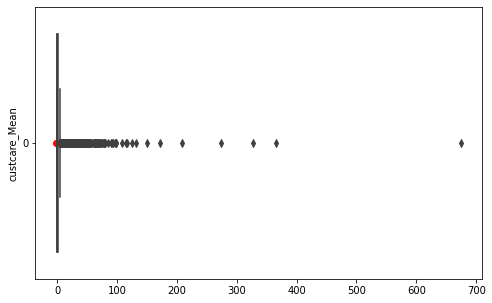

Lower limit of custcare_Mean is -3.0
Upper limit of custcare_Mean is 4.0


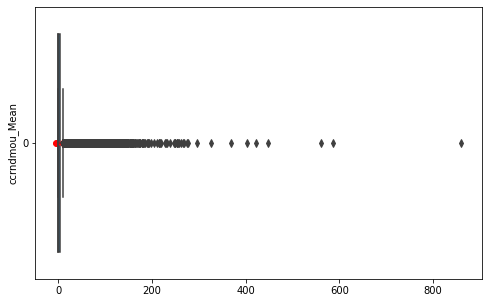

Lower limit of ccrndmou_Mean is -6.0
Upper limit of ccrndmou_Mean is 10.0


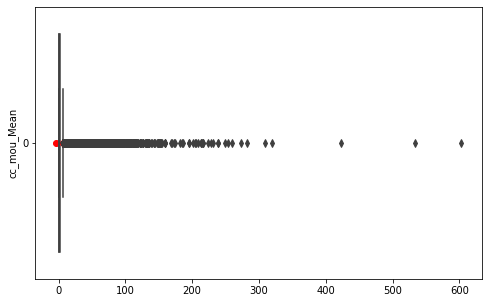

Lower limit of cc_mou_Mean is -4.0
Upper limit of cc_mou_Mean is 7.0


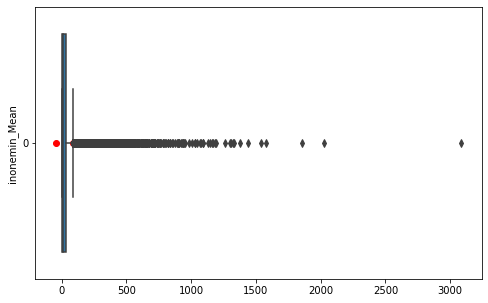

Lower limit of inonemin_Mean is -47.0
Upper limit of inonemin_Mean is 85.0


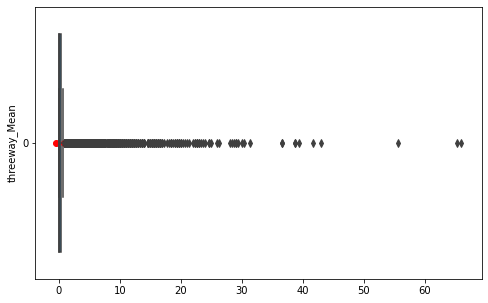

Lower limit of threeway_Mean is -0.0
Upper limit of threeway_Mean is 1.0


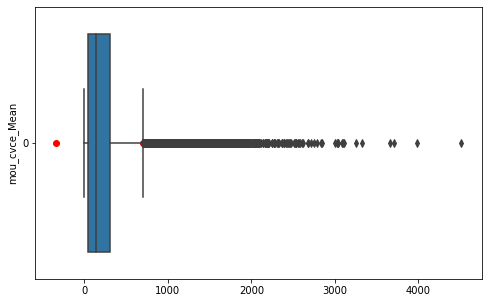

Lower limit of mou_cvce_Mean is -342.0
Upper limit of mou_cvce_Mean is 700.0


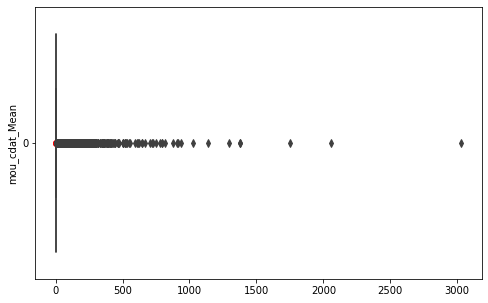

Lower limit of mou_cdat_Mean is 0.0
Upper limit of mou_cdat_Mean is 0.0


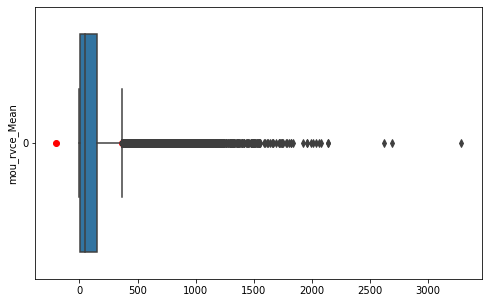

Lower limit of mou_rvce_Mean is -205.0
Upper limit of mou_rvce_Mean is 362.0


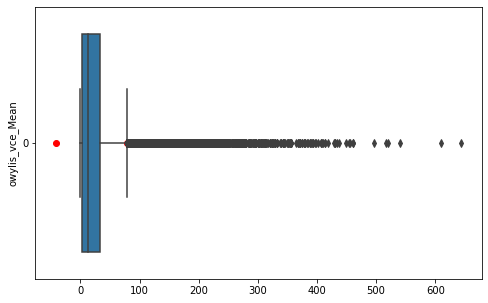

Lower limit of owylis_vce_Mean is -42.0
Upper limit of owylis_vce_Mean is 78.0


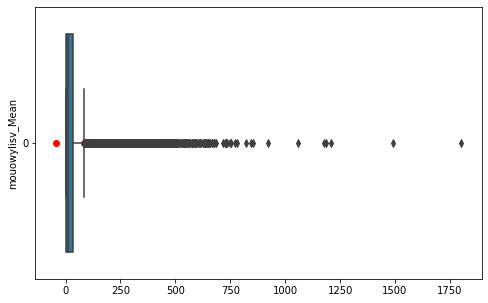

Lower limit of mouowylisv_Mean is -45.0
Upper limit of mouowylisv_Mean is 82.0


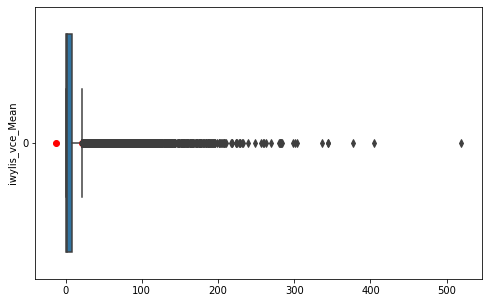

Lower limit of iwylis_vce_Mean is -13.0
Upper limit of iwylis_vce_Mean is 22.0


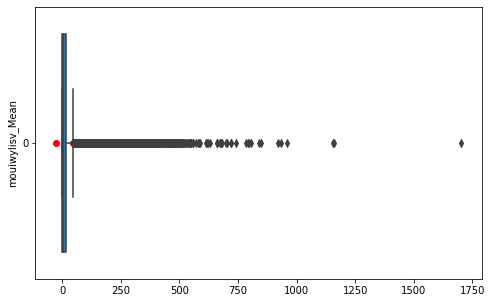

Lower limit of mouiwylisv_Mean is -27.0
Upper limit of mouiwylisv_Mean is 46.0


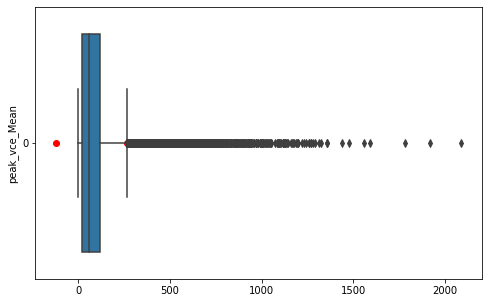

Lower limit of peak_vce_Mean is -124.0
Upper limit of peak_vce_Mean is 264.0


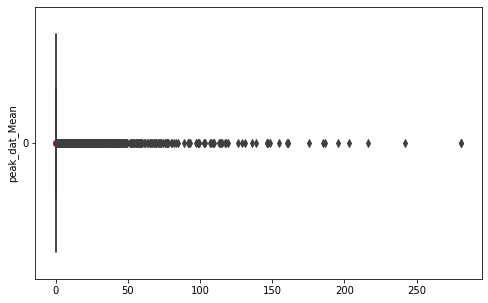

Lower limit of peak_dat_Mean is 0.0
Upper limit of peak_dat_Mean is 0.0


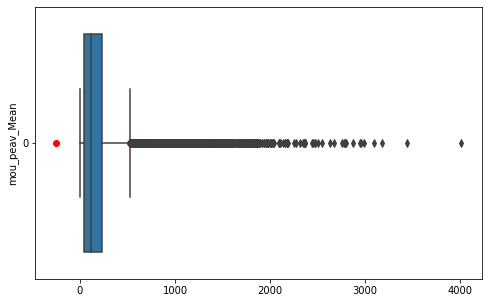

Lower limit of mou_peav_Mean is -256.0
Upper limit of mou_peav_Mean is 527.0


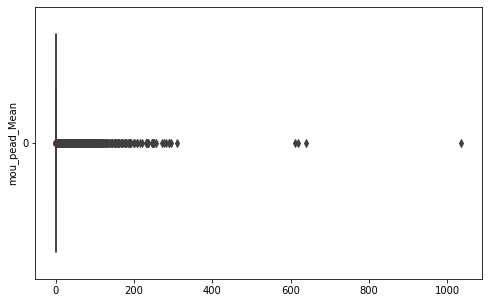

Lower limit of mou_pead_Mean is 0.0
Upper limit of mou_pead_Mean is 0.0


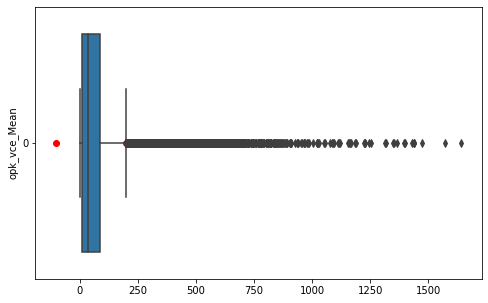

Lower limit of opk_vce_Mean is -104.0
Upper limit of opk_vce_Mean is 200.0


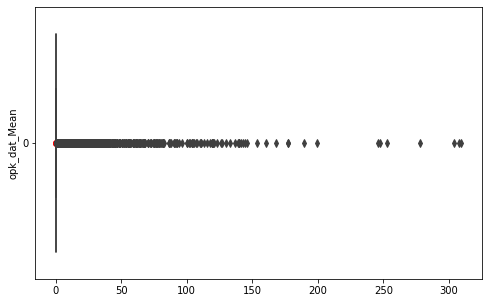

Lower limit of opk_dat_Mean is 0.0
Upper limit of opk_dat_Mean is 0.0


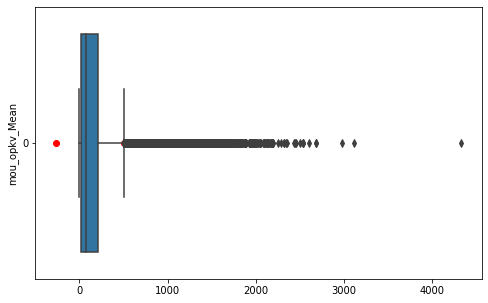

Lower limit of mou_opkv_Mean is -270.0
Upper limit of mou_opkv_Mean is 500.0


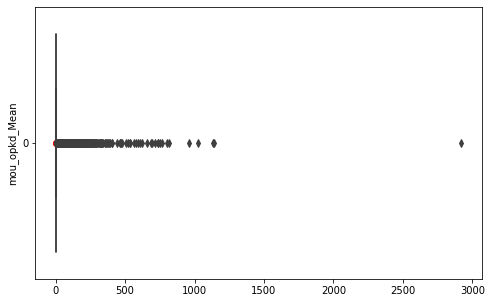

Lower limit of mou_opkd_Mean is 0.0
Upper limit of mou_opkd_Mean is 0.0


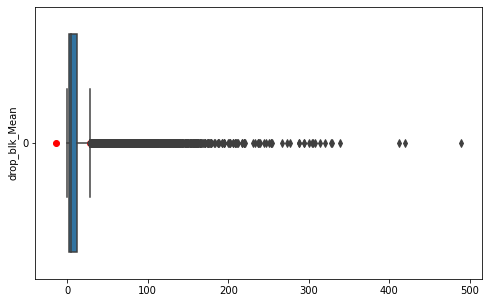

Lower limit of drop_blk_Mean is -14.0
Upper limit of drop_blk_Mean is 28.0


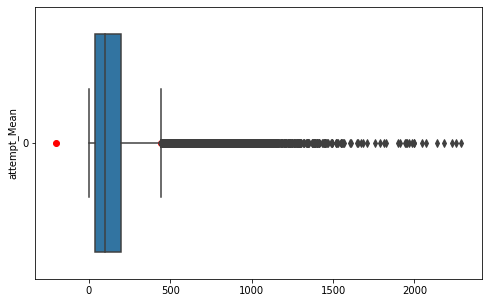

Lower limit of attempt_Mean is -204.0
Upper limit of attempt_Mean is 442.0


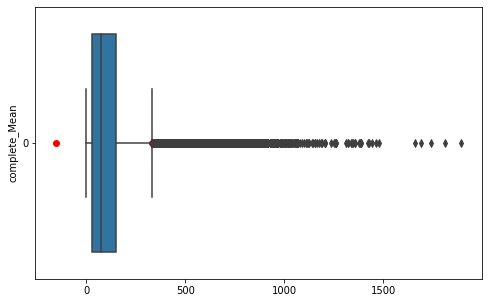

Lower limit of complete_Mean is -154.0
Upper limit of complete_Mean is 334.0


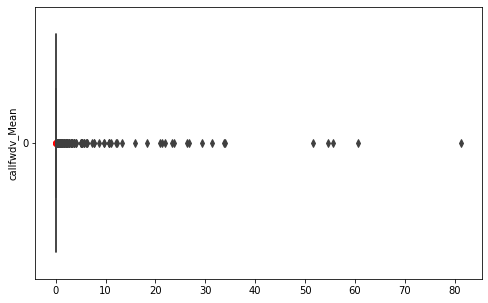

Lower limit of callfwdv_Mean is 0.0
Upper limit of callfwdv_Mean is 0.0


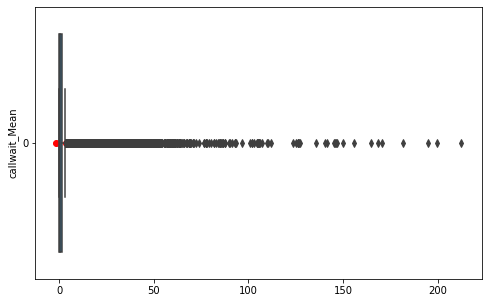

Lower limit of callwait_Mean is -2.0
Upper limit of callwait_Mean is 3.0


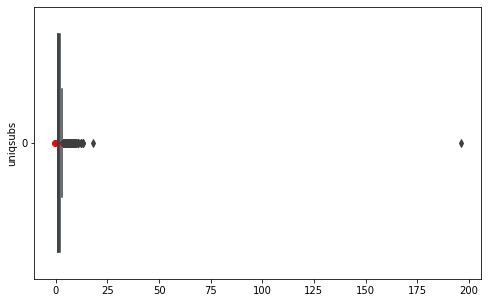

Lower limit of uniqsubs is -0.0
Upper limit of uniqsubs is 4.0


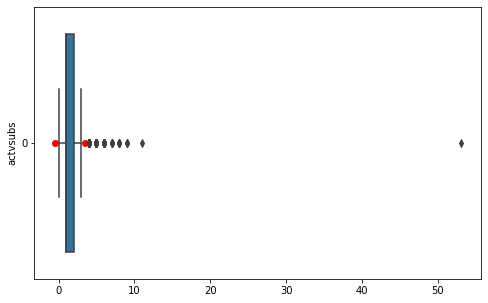

Lower limit of actvsubs is -0.0
Upper limit of actvsubs is 4.0


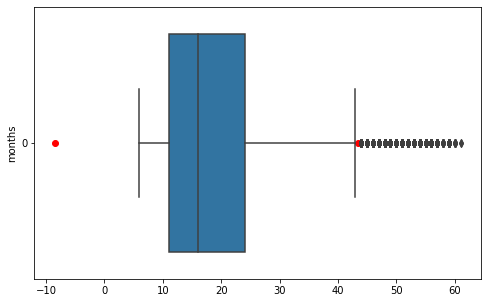

Lower limit of months is -8.0
Upper limit of months is 44.0


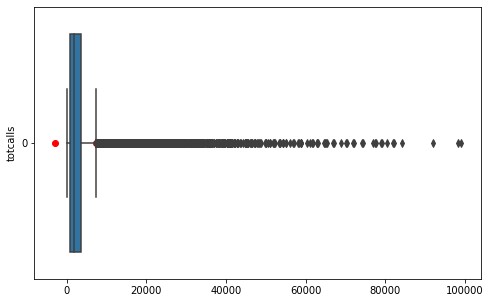

Lower limit of totcalls is -3016.0
Upper limit of totcalls is 7396.0


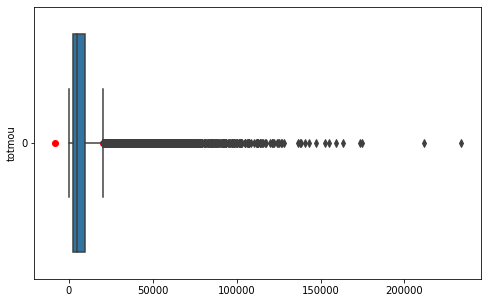

Lower limit of totmou is -8342.0
Upper limit of totmou is 20646.0


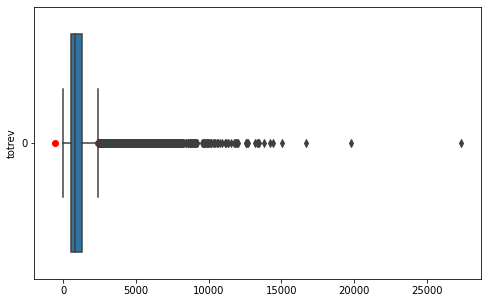

Lower limit of totrev is -598.0
Upper limit of totrev is 2381.0


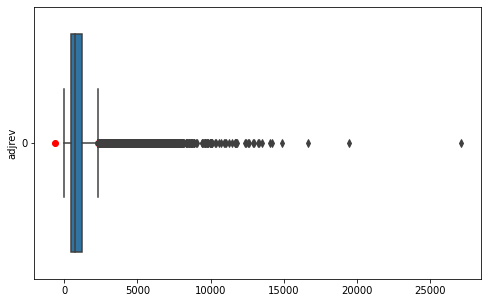

Lower limit of adjrev is -652.0
Upper limit of adjrev is 2292.0


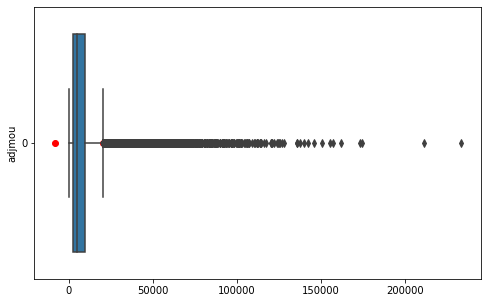

Lower limit of adjmou is -8306.0
Upper limit of adjmou is 20442.0


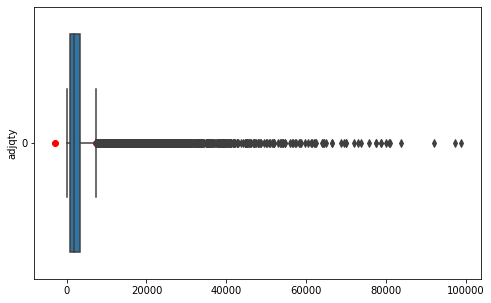

Lower limit of adjqty is -2993.0
Upper limit of adjqty is 7303.0


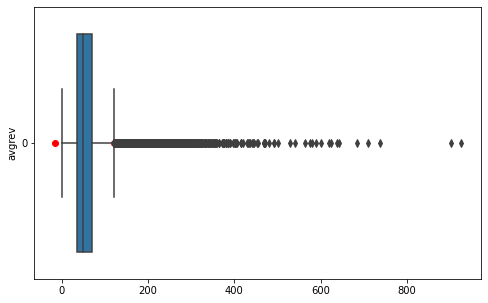

Lower limit of avgrev is -16.0
Upper limit of avgrev is 121.0


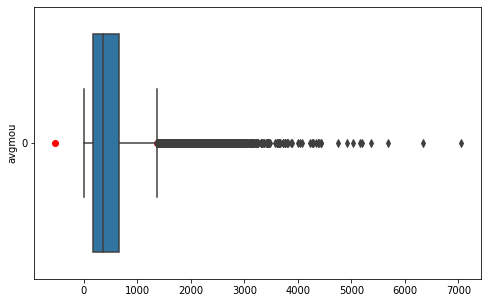

Lower limit of avgmou is -543.0
Upper limit of avgmou is 1375.0


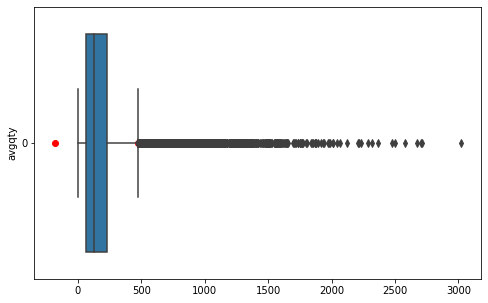

Lower limit of avgqty is -183.0
Upper limit of avgqty is 475.0


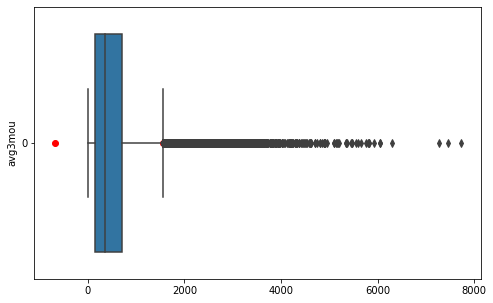

Lower limit of avg3mou is -686.0
Upper limit of avg3mou is 1550.0


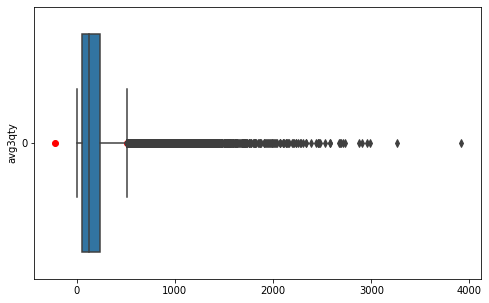

Lower limit of avg3qty is -222.0
Upper limit of avg3qty is 518.0


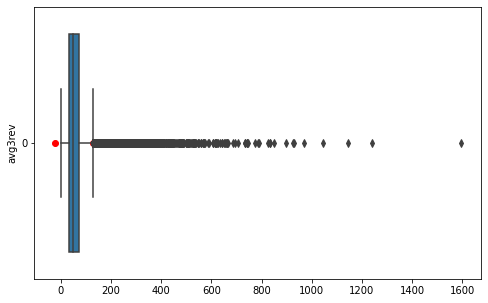

Lower limit of avg3rev is -24.0
Upper limit of avg3rev is 128.0


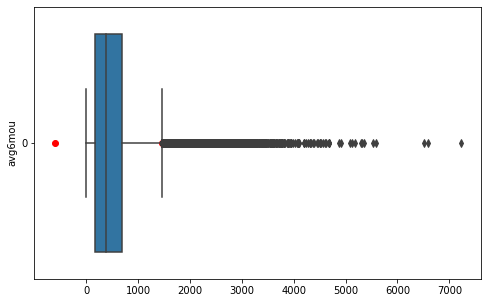

Lower limit of avg6mou is -604.0
Upper limit of avg6mou is 1456.0


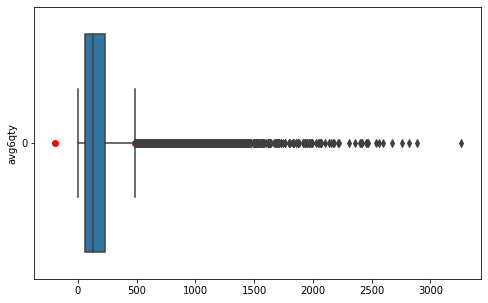

Lower limit of avg6qty is -196.0
Upper limit of avg6qty is 488.0


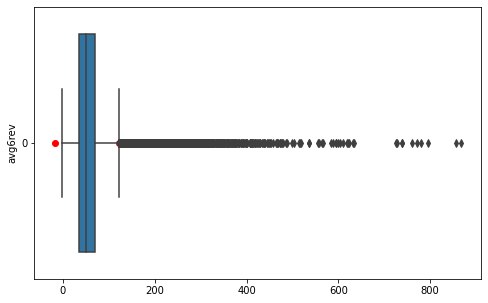

Lower limit of avg6rev is -18.0
Upper limit of avg6rev is 122.0


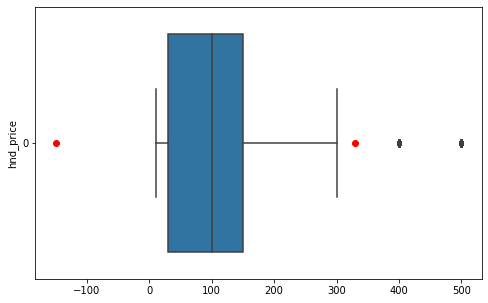

Lower limit of hnd_price is -150.0
Upper limit of hnd_price is 330.0


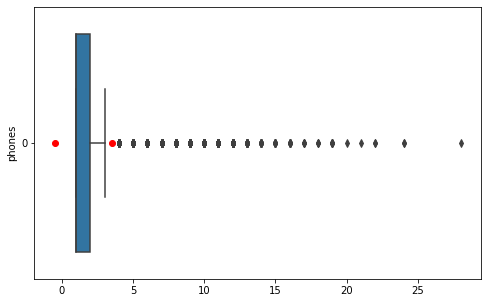

Lower limit of phones is -0.0
Upper limit of phones is 4.0


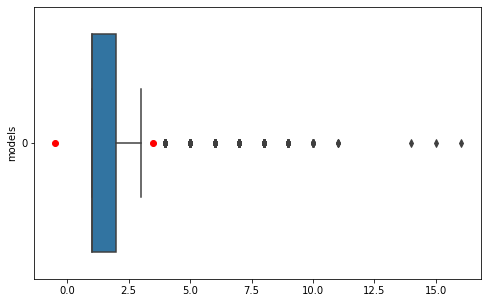

Lower limit of models is -0.0
Upper limit of models is 4.0


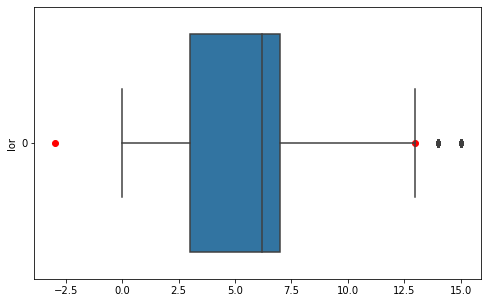

Lower limit of lor is -3.0
Upper limit of lor is 13.0


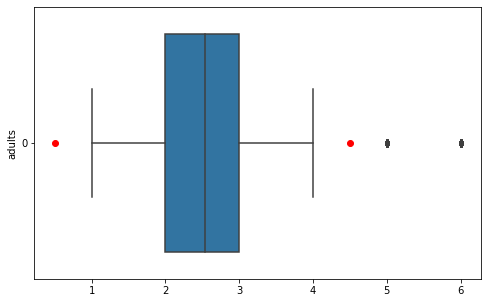

Lower limit of adults is 0.0
Upper limit of adults is 4.0


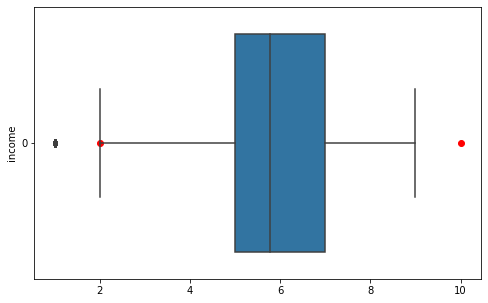

Lower limit of income is 2.0
Upper limit of income is 10.0


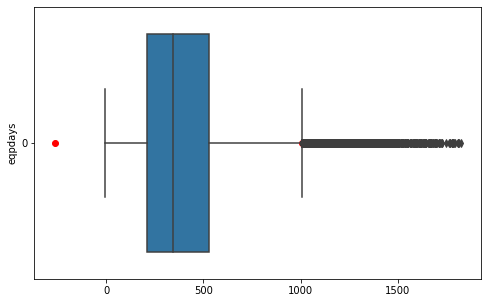

Lower limit of eqpdays is -265.0
Upper limit of eqpdays is 1007.0


In [17]:
# Almost all columns have outliers.
col_num = list(numerical_feat_final.columns)

dimentions = (8, 5)
whis = 1.5
df_outliers = pd.DataFrame(columns=['col_name', 'limit_upper', 'limit_lower', 'outlier_num', 'outlier_per'])

for col in col_num:
    
    fig, ax = plt.subplots(figsize = dimentions)
    q1 = numerical_feat_final[col].quantile(0.25)
    q3 = numerical_feat_final[col].quantile(0.75)
    iqr = q3 - q1
    limit_lower = q1 - whis*iqr
    limit_upper = q3 + whis*iqr
    sns.boxplot(data = numerical_feat_final[col], orient = "h", whis = whis)
    plt.scatter(limit_lower, 0, color = 'red')
    plt.scatter(limit_upper, 0, color = 'red')
    plt.ylabel(col)
    plt.show()
    
    print("Lower limit of" , col , "is" , round(limit_lower))
    print("Upper limit of" , col , "is" , round(limit_upper))
    
    outliers_num = numerical_feat_final[(numerical_feat_final[col] > limit_upper) | (numerical_feat_final[col] < limit_lower)].shape[0]
    outliers_per = outliers_num / numerical_feat_final.shape[0] * 100
    df_outliers = df_outliers.append({'col_name': col, 'limit_upper': round(limit_upper),'limit_lower': round(limit_lower), 'outlier_num': outliers_num, 'outlier_per': outliers_per}, ignore_index = True)

In [18]:
#Columns that contain outliers:
#73 columns
#Too much outliers to be removed. We will need to consider data scaling when training the model
#And also a scaler that works well with outliers
outliers = df_outliers[df_outliers.outlier_per > 0]
df_outliers

,col_name,limit_upper,limit_lower,outlier_num,outlier_per
0,rev_Mean,127.0,-23.0,6030,6.030
1,mou_Mean,1526.0,-673.0,5201,5.201
2,totmrc_Mean,105.0,-15.0,1800,1.800
3,da_Mean,2.0,-1.0,11994,11.994
4,ovrmou_Mean,105.0,-63.0,11527,11.527
...,...,...,...,...,...
68,models,4.0,-0.0,3863,3.863
69,lor,13.0,-3.0,9399,9.399
70,adults,4.0,0.0,9167,9.167
71,income,10.0,2.0,4033,4.033


In [19]:
outliers = df_outliers[df_outliers.outlier_per > 10]
#Columns that have more than 10% of outliers in the data. Which is a lot already.
list(outliers.col_name)

['da_Mean',
 'ovrmou_Mean',
 'ovrrev_Mean',
 'vceovr_Mean',
 'datovr_Mean',
 'roam_Mean',
 'change_mou',
 'change_rev',
 'blck_vce_Mean',
 'plcd_dat_Mean',
 'comp_dat_Mean',
 'custcare_Mean',
 'ccrndmou_Mean',
 'cc_mou_Mean',
 'mou_cdat_Mean',
 'iwylis_vce_Mean',
 'mouiwylisv_Mean',
 'callwait_Mean']

#### 2.2 Correlation between numerical variables

In [20]:
#See the correlation between the numerical variables
numerical_means = numerical_feat_final[['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean', 
                                        'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean', 'comp_dat_Mean', 'custcare_Mean',
                                        'ccrndmou_Mean', 'cc_mou_Mean', 'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean', 'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean', 'iwylis_vce_Mean',
                                        'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 
                                        'attempt_Mean', 'complete_Mean', 'callfwdv_Mean', 'callwait_Mean']]


numerical_avg = numerical_feat_final[['adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou', 'avgqty', 'avg3mou', 'avg3qty', 'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev']]

In [21]:
def heatmap(corr_data):
    plt.figure(figsize = (35,20))
    sns.heatmap(data = corr_data, annot = True, cmap = plt.cm.Reds, fmt = '.1')
    plt.show()

In [22]:
sperman_corr_mean_data = numerical_means.corr(method = 'spearman')

sperman_corr_avg_data = numerical_avg.corr(method = 'spearman')

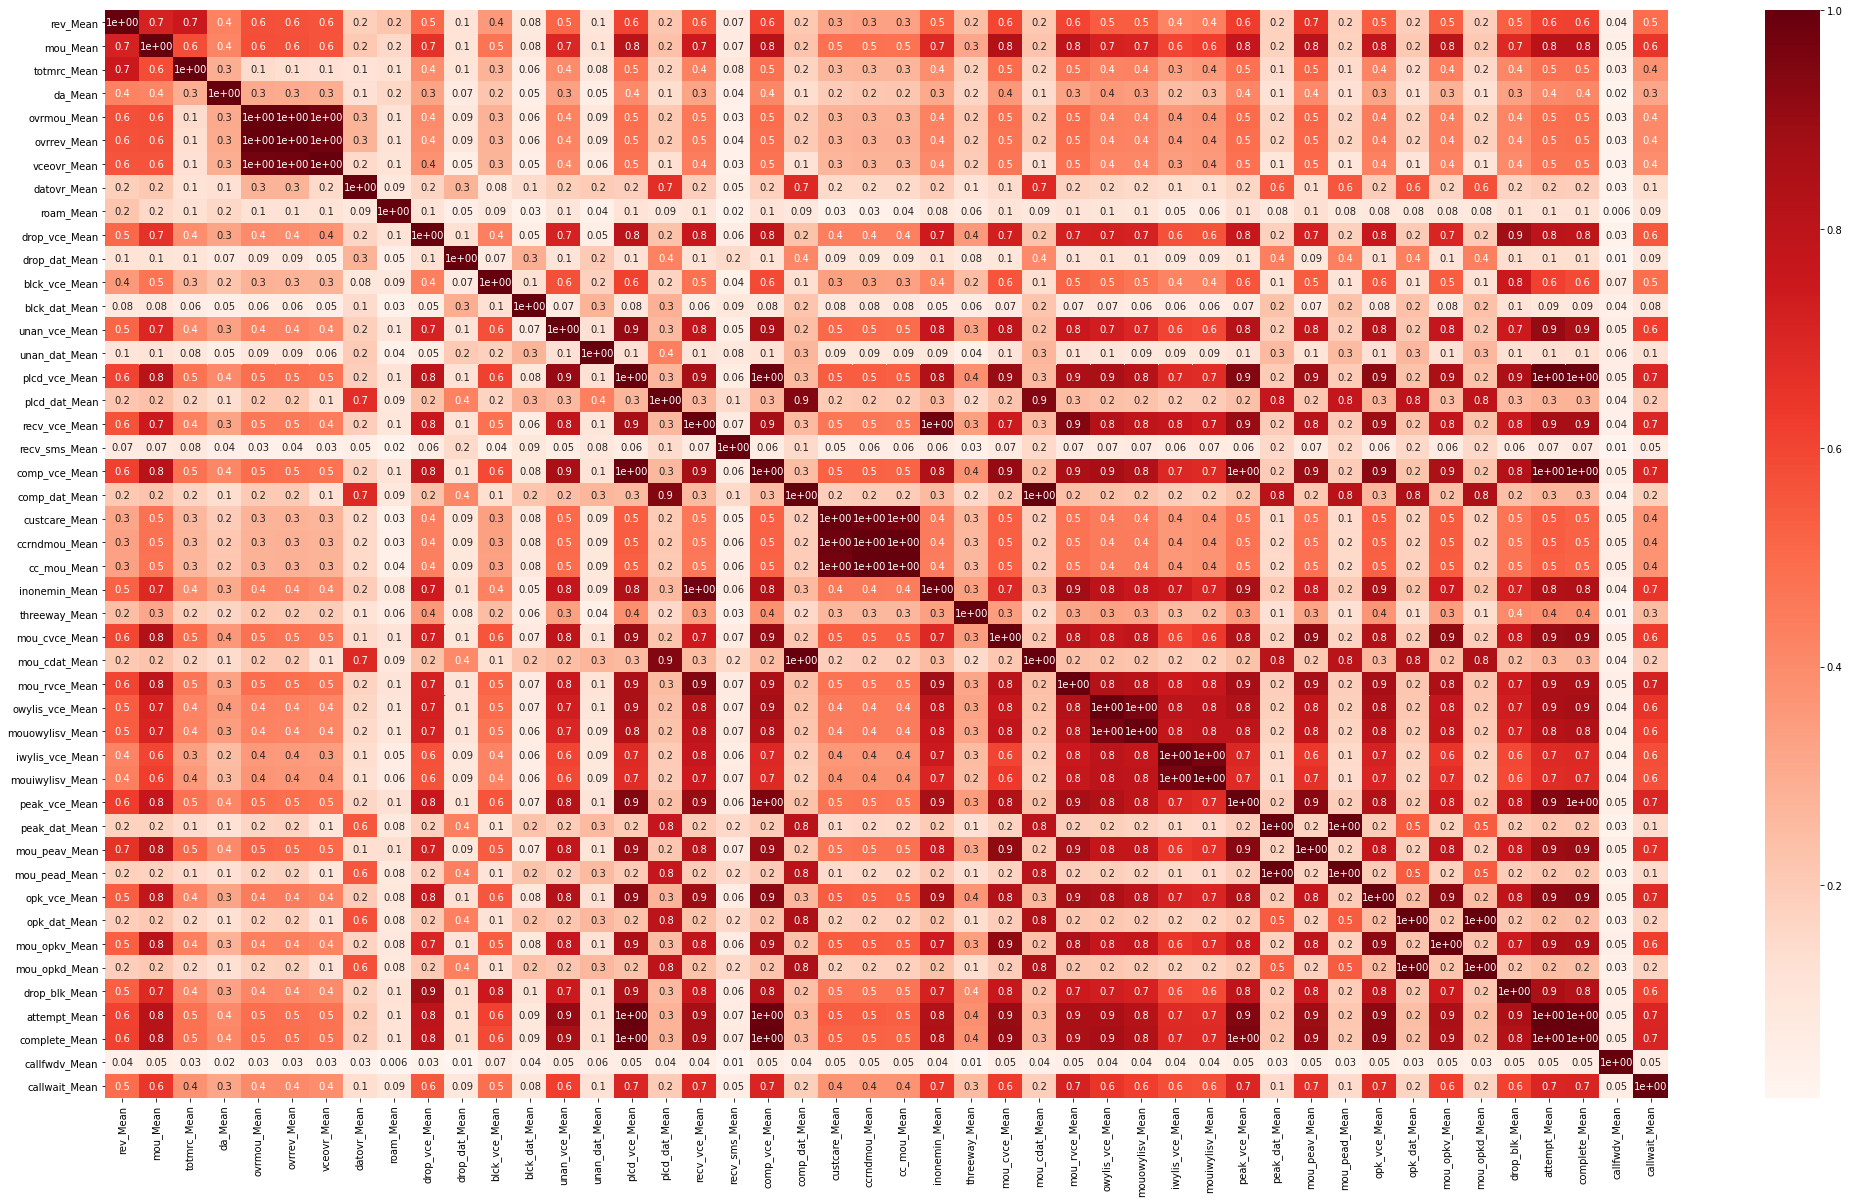

In [23]:
heatmap(sperman_corr_mean_data)
#After evaluating the heatmap we can see that lots of variable have correlation of 1, which means they explain each other. 
#Therefore we can remove the columns: ovrmou_Mean, vceovr_Mean, recv_vce_Mean, comp_vce_Mean, ccrndmou_Mean, cc_mou_Mean, mou_cdat_Mean, owylis_vce_Mean, iwylis_vce_Mean, mou_pead_Mean,
#mou_opkd_Mean, attempt_Mean and complete_Mean.

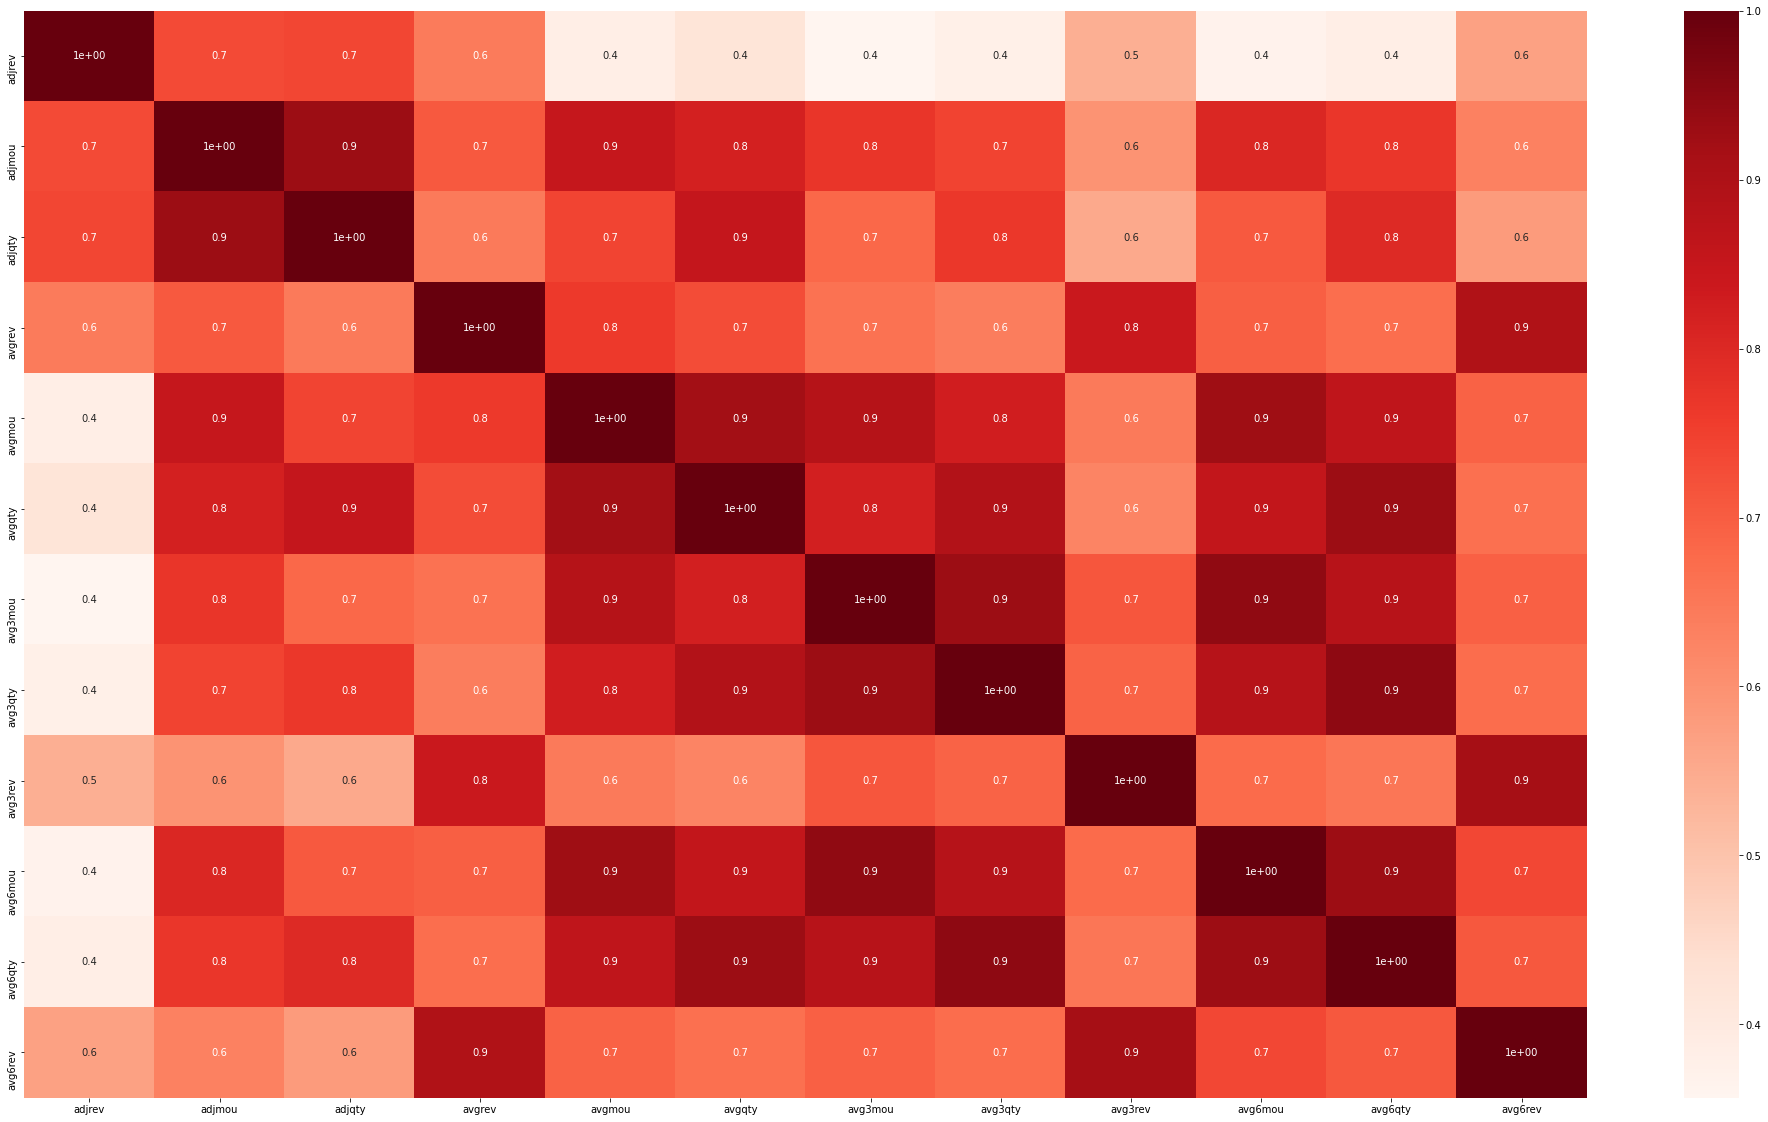

In [24]:
heatmap(sperman_corr_avg_data)
#We are not going to remove any of the avg variables for now.

In [25]:
#Now, let's check if the remaining mean variables are correlated with the avg ones:
sperman_corr_all_data = numerical_feat_final[['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrrev_Mean', 'datovr_Mean', 'roam_Mean', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean',
                                              'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'recv_sms_Mean', 'comp_dat_Mean', 'custcare_Mean', 'inonemin_Mean',
                                              'threeway_Mean', 'mou_cvce_Mean',  'mou_rvce_Mean',  'mouowylisv_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'opk_vce_Mean',
                                              'opk_dat_Mean', 'mou_opkv_Mean', 'drop_blk_Mean', 'callfwdv_Mean', 'callwait_Mean', 'adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou', 'avgqty', 'avg3mou', 'avg3qty',
                                              'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev']]

sperman_all_data = sperman_corr_all_data.corr(method = 'spearman')

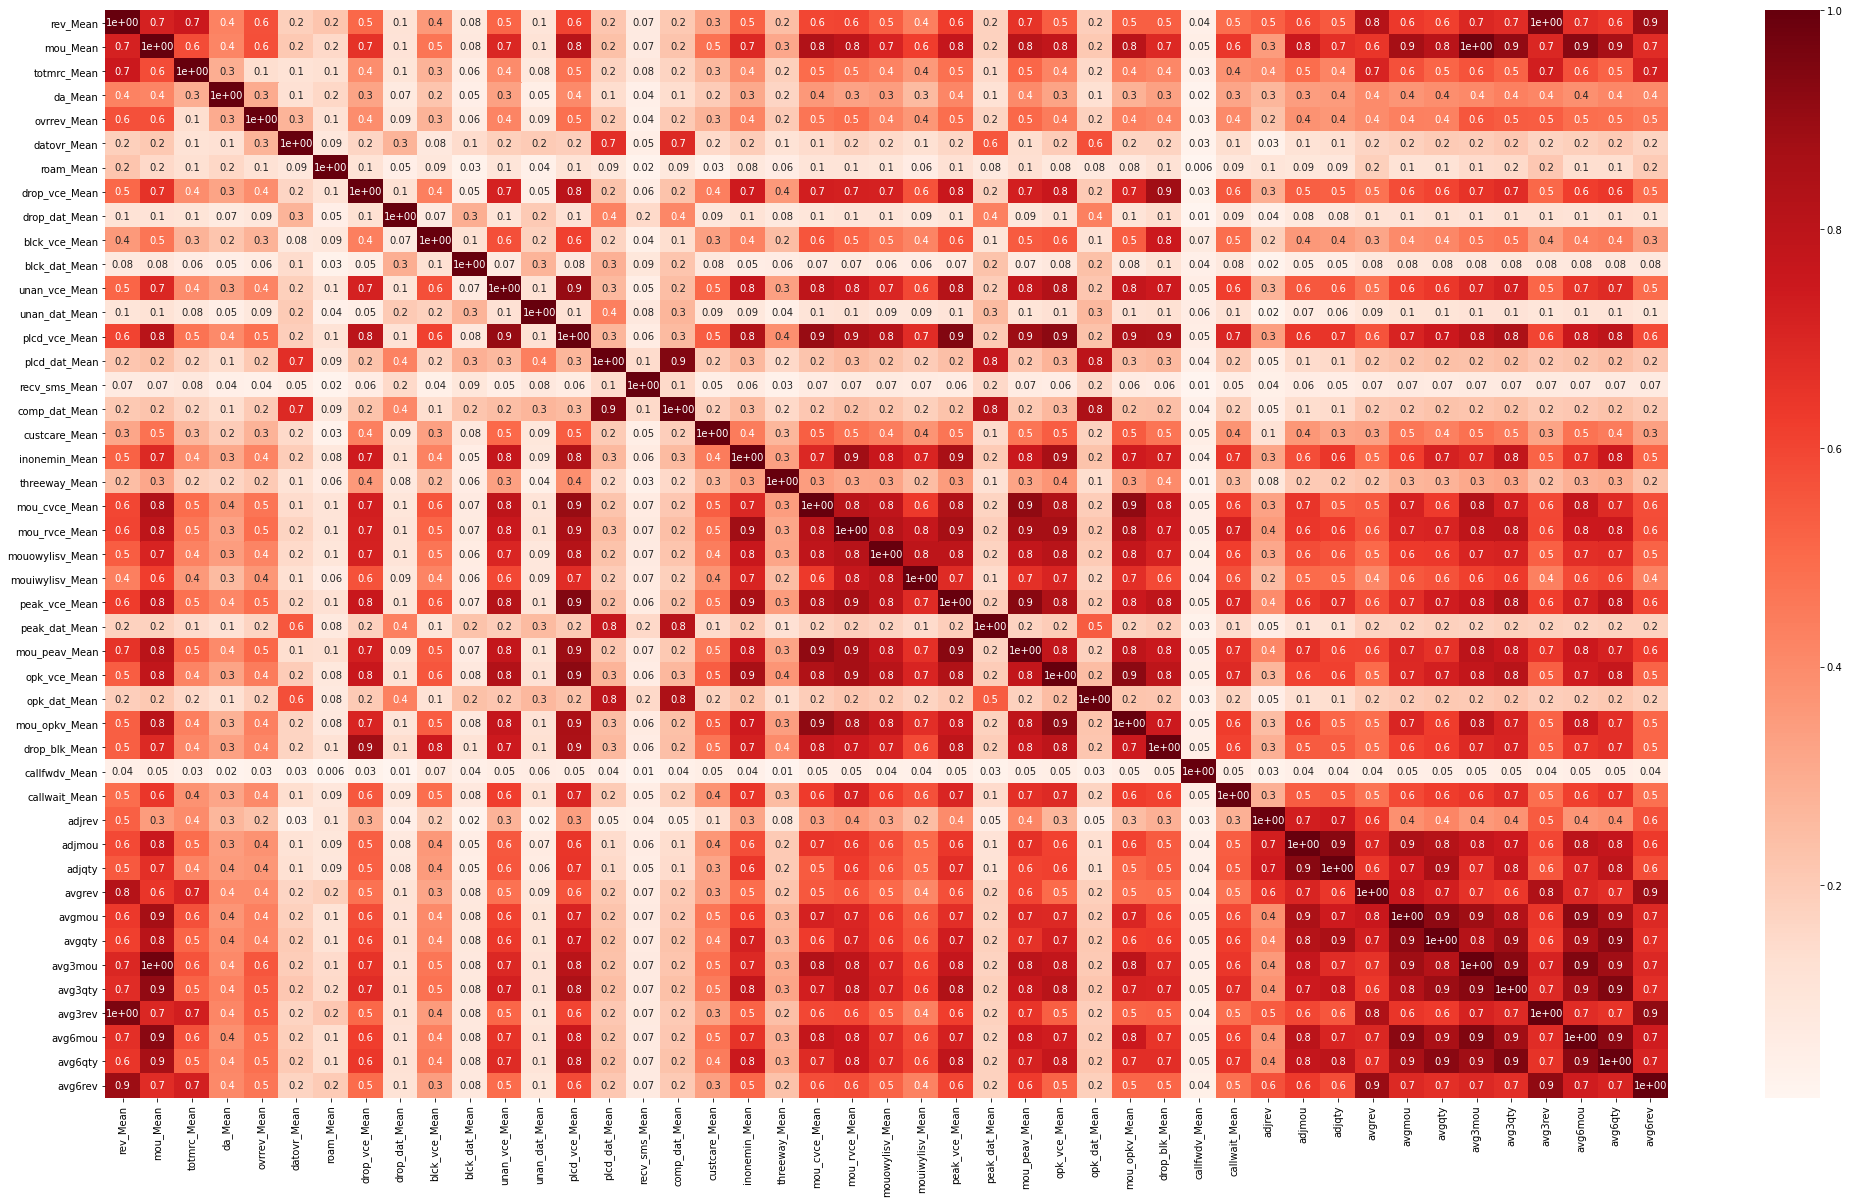

In [26]:
#We can also remove avg_3mou and avg_3rev as they have correlation of 1 with rev_Mean and mou_Mean respectively.
heatmap(sperman_all_data)

In [27]:
numerical_feat_final = numerical_feat_final[['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean','ovrrev_Mean', 'datovr_Mean', 'roam_Mean', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean', 'blck_dat_Mean', 
                                             'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'recv_sms_Mean', 'comp_dat_Mean', 'custcare_Mean', 'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean',
                                             'mou_rvce_Mean', 'mouowylisv_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkv_Mean', 'drop_blk_Mean',
                                             'callfwdv_Mean', 'callwait_Mean', 'adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou', 'avgqty','avg3qty','avg6mou', 'avg6qty', 'avg6rev']]


numerical_feat_final.shape
#From now on we go with 43 numerical variables.

(100000, 43)

### 3. Feature importance

In [28]:
#Let's encode the categorical variables
encoder = LabelEncoder()

In [29]:
categorical_feat_enc = categorical_feat_final.apply(encoder.fit_transform)
#categorical_feat_final.head()

#### 3.1 Numerical variables

In [30]:
#Let's now find out what are the best features to predict the target variable.
#Let's start by the numerical variables.
#Because the input is numerical and the output is categorical we are going to implement ANOVA algorithm.

X_numerical = numerical_feat_final.to_numpy()

y_target = target.to_numpy()

In [31]:
#Creates a SelectKBest object to select features with two best ANOVA F-Values
model = SelectKBest(score_func = f_classif, k = 'all')

#Applies the SelectKBest object to the features and target
best = model.fit_transform(X_numerical, y_target)

p_values = model.pvalues_
scores = model.scores_

In [32]:
X_numerical = numerical_feat_final.to_numpy()

X_indices = np.arange(X_numerical.shape[-1])

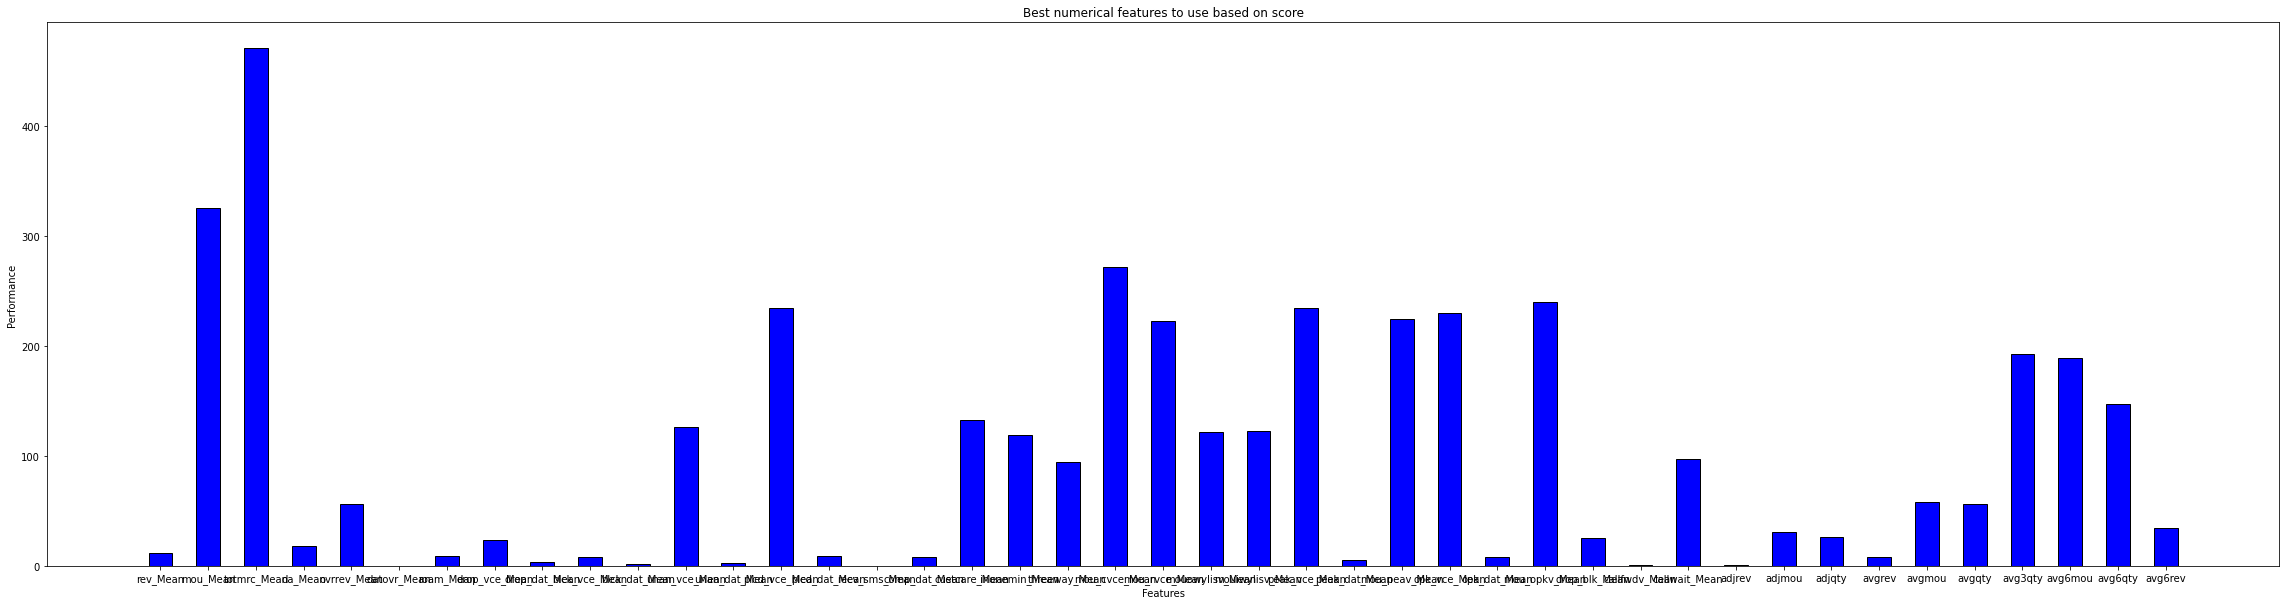

In [33]:
fig, ax = plt.subplots(figsize = (40, 10))

x = numerical_feat_final.columns
x_pos = [i for i, _ in enumerate(x)]

plt.bar(X_indices, scores, width = 0.5, color = 'blue', edgecolor = 'black')
plt.title('Best numerical features to use based on score')
plt.xticks(x_pos, x)
plt.ylabel('Performance')
plt.xlabel('Features')
plt.show()

#We need to try to fix this in order to see the variables names better.

In [34]:
#This plot is not very useful because we have too many features
#But we can still eliminate the ones that have a really low score comparing with the maximum, which is around 400.
def lower_score(list_of_col_names, list_of_scores):
    
    df_feat_scores = pd.DataFrame({'col_name': list_of_col_names, 'scores': list_of_scores})
    print(df_feat_scores.scores.max())
          
    low_score = df_feat_scores[df_feat_scores.scores < 1]
    features_low_score = list(low_score.col_name)
          
    return features_low_score
          

In [35]:
numerical_low_score = lower_score(list(numerical_feat_final.columns), list(scores))

470.5179217928696


In [36]:
numerical_feat_final = numerical_feat_final.drop(numerical_low_score, axis = 1)
#numerical_feat_final.shape

#### 3.2 Categorical variables

In [38]:
#Let's now see what are the best categorical feature to predict the target variable.
#Because the input is categorical and the output is categorical we are going to implement chi-squared algorithm.

X_categorical = categorical_feat_enc.to_numpy()

model = SelectKBest(chi2, k = 'all') 
best = model.fit_transform(X_categorical, y_target) 

p_values = model.pvalues_
scores = model.scores_
print("p-values: ", p_values)
print("Scores: ", scores)

p-values:  [4.71886010e-01 0.00000000e+00 2.45762841e-92 2.88021044e-01
 3.54249168e-14 9.83111898e-21 1.40369616e-20 5.16016913e-05
 2.82273425e-01 8.40860445e-01 3.29568894e-02 6.17413799e-01
 4.78995344e-04 7.53482771e-07 1.41041524e-01 1.50312232e-20
 2.76646603e-03 2.81725191e-01]
Scores:  [5.17556184e-01 1.80371857e+03 4.15391673e+02 1.12884871e+00
 5.74075260e+01 8.71954201e+01 8.64910714e+01 1.63883399e+01
 1.15611159e+00 4.03178245e-02 4.54801725e+00 2.49519239e-01
 1.21957103e+01 2.44732615e+01 2.16655893e+00 8.63557319e+01
 8.95542643e+00 1.15874875e+00]


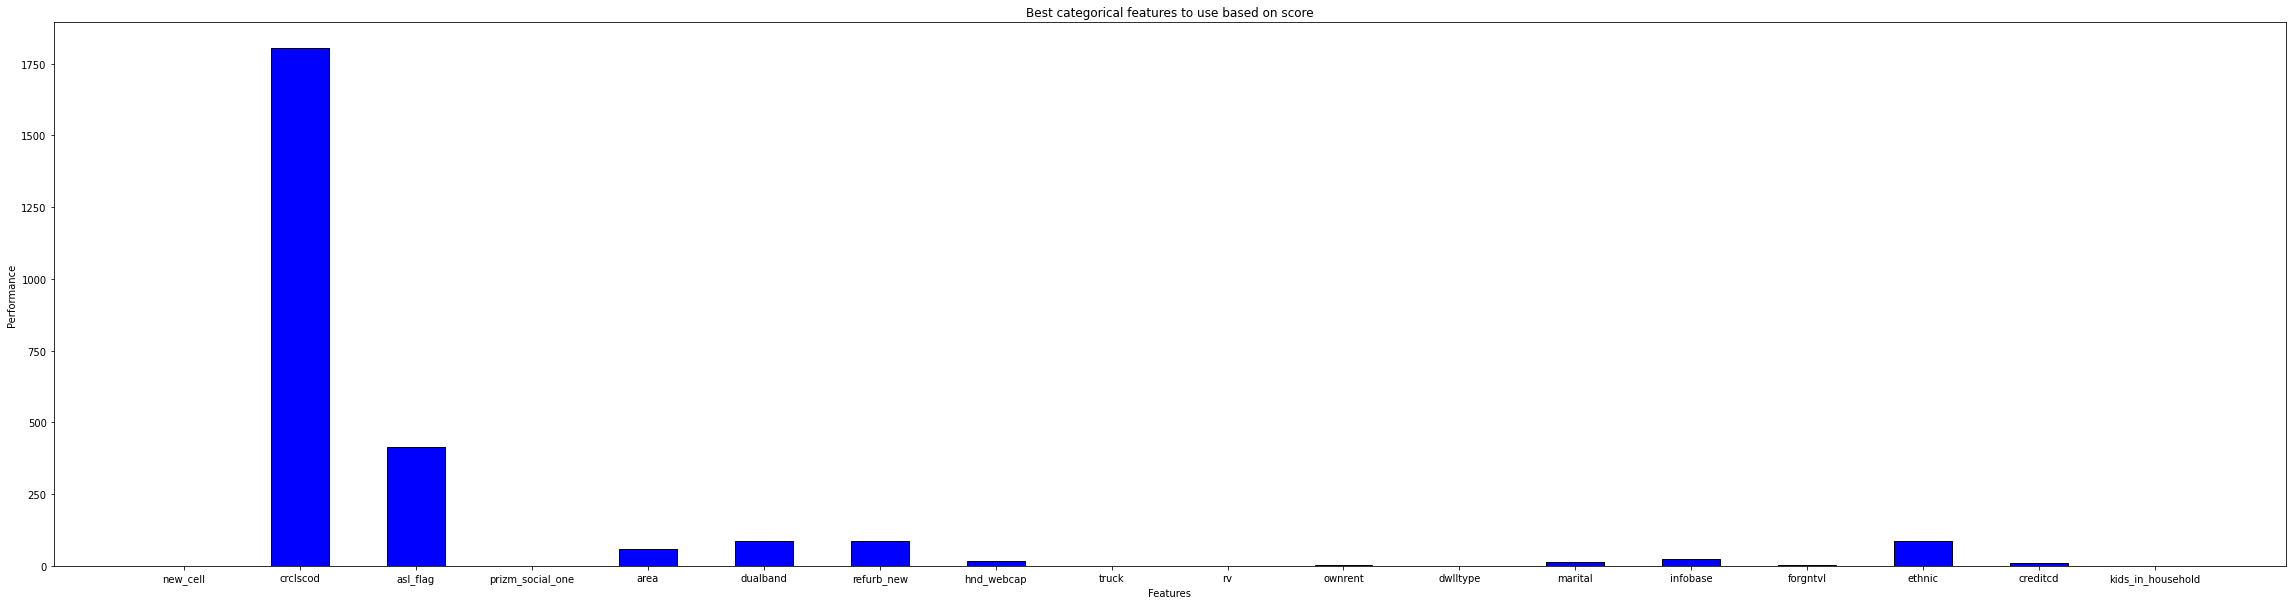

In [39]:
fig, ax = plt.subplots(figsize = (40, 10))

X_indices = np.arange(X_categorical.shape[-1])
x = categorical_feat_final.columns
x_pos = [i for i, _ in enumerate(x)]

plt.bar(X_indices, scores, width = 0.5, color = 'blue', edgecolor = 'black')
plt.title('Best categorical features to use based on score')
plt.xticks(x_pos, x)
plt.ylabel('Performance')
plt.xlabel('Features')
plt.show()

In [40]:
categorical_low_score = lower_score(list(categorical_feat_enc.columns), list(scores))

1803.718569640151


In [41]:
#We can for a start to remove the variables that have score close to zero.
categorical_features_final = categorical_feat_final.drop(categorical_low_score, axis = 1)
#categorical_features_final.shape

In [42]:
#Now that we removed the categorical features that had 0 as score, we need to go back to the encoding type
#The encoding we chose will not work with the cell bellow.
#This involves creating binary columns for each category in the original feature.
#This method will increase the dimensionality of the dataset, but it will allow
#the inclusion of categorical data in machine learning models.

categorical_final = pd.get_dummies(categorical_features_final, columns = list(categorical_features_final.columns))

#categorical_finals.shape

In [44]:
features_all = pd.concat([numerical_feat_final, categorical_final], axis = 1)
features_all.shape

(100000, 162)

In [45]:
#X_all = features_all.to_numpy()

In [75]:
"""
#number of features
nof_list = np.arange(1, numerical_feat_final.shape[1])

high_score = 0

#Variable to store the optimum features
nof = 0           
score_list = []

for n in range(len(nof_list)):
    
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_target, test_size = 0.2, random_state = 42, stratify = y_target)
    
    #scaler.fit(X_train)
    #X_train = scaler.transform(X_train)
    #X_test = scaler.transform(X_test)

    #Replace here with the model you want
    model = LogisticRegression()
    rfe = RFE(model, nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)

    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    print(score)

    if(score > high_score):
        high_score = score
        nof = nof_list[n]
        
"""

'\n#number of features\nnof_list = np.arange(1, numerical_feat_final.shape[1])\n\nhigh_score = 0\n\n#Variable to store the optimum features\nnof = 0           \nscore_list = []\n\nfor n in range(len(nof_list)):\n    \n    X_train, X_test, y_train, y_test = train_test_split(X_all, y_target, test_size = 0.2, random_state = 42, stratify = y_target)\n    \n    #scaler.fit(X_train)\n    #X_train = scaler.transform(X_train)\n    #X_test = scaler.transform(X_test)\n\n    #Replace here with the model you want\n    model = LogisticRegression()\n    rfe = RFE(model, nof_list[n])\n    X_train_rfe = rfe.fit_transform(X_train, y_train)\n    X_test_rfe = rfe.transform(X_test)\n    model.fit(X_train_rfe, y_train)\n\n    score = model.score(X_test_rfe, y_test)\n    score_list.append(score)\n    print(score)\n\n    if(score > high_score):\n        high_score = score\n        nof = nof_list[n]\n        \n'

In [ ]:
#print("Optimum number of features: %d" %nof)
#print("Score with %d features: %f" % (nof, high_score))

In [ ]:
##test_set = 0.3
##Without removing the correlated features:

#Without outliers and DT: 42 features, 55%
#With outliers and DT: 34 features, 55%

#Without ouliers and RF:
#With outliers and RF: 63 features, 62%

##test_set = 0.2:
#with outliers, DT and stratify: 53 features, 55%

#------
##After correlation features removal:

#with outliers and DT: 26 features, 53%
#with outliers and RF: 35 features, 58%
#with outliers and LR: 23 features, 56%

#without outliers and DT: 24 features, 53%
#without outliers and RF: 34 features, 58%
#without outliers and LR: 18 features, 56%

#Without outliers and LR with scaled data: 18 features, 56%
#With outliers and LR with scaled data:

#With LR, try also to remove all outliers and not the column that have lots of them.
#without outliers at all and LR: 18 features, 56%

## --------------------

## test_set = 0.2 and removing correlated features
#with outliers, LR and stratify: 22 features, 57%
#with outliers, DT and stratify:  31 features, 53%
#with outliers, RF and stratify: 37 features, 58%

### 4. Feature selection

In [80]:
scaler = RobustScaler()

Before blindly applying GridSearchCV with all the possible hyperparameter values for the algorithms used, a few preliminary tests were run in order to get a general idea of which parameters would be better than others. Here, not all tests that were run are shown, but only the example of the MLPClassifier. These and all tests were done using 5-fold cross validation in order to strike a balance between avoiding overfitting but also having enough data in the test set for the tests to be relevant. Since using 5-fold cross validation means that the train/test split will be 80%/20%, which is a common split, and that the test set has approximately 180 instances, this was the chosen split for the tests that were run.

In [82]:
def avg_score(model_, scaler, features, grid_search):
    
    # apply kfold
    kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    n_iter = []
    
    for train_index, test_index in kf.split(features_all, target):
        model = deepcopy(model_)
        # get the indexes of the observations assigned for each partition
        X_train, X_test = features_all.iloc[train_index], features_all.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # scale the data
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # start counting time
        begin = time.perf_counter()
        
        # find the best features
        if features == True:
            rfe = RFECV(estimator = model, n_jobs = -1, scoring = 'accuracy')
            X_train = rfe.fit_transform(X_train,y_train)
            X_test = rfe.transform(X_test)

            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            #print("Best model score: ", score)
            #print("Number of feature to use: ", X_train.shape[1])
            #print("Features ranking: ", rfe.ranking_)
        
        # find the best hyperparameters
        if grid_search == True:
            clf = StratifiedKFold(model, parameters, n_jobs = -1, scoring = 'accuracy')
            clf.fit(X_train,y_train)
            model = clf.best_estimator_
            #print(clf.best_params_)
        
        # fit the model to the data
        #print(model)
        model.fit(X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        
        # predictions
        Y_pred = model.predict(X_train)
        y_pred = model.predict(X_test)
        
        # check the mean accuracy for the train
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_test, y_test)
       
        #print a classification report and confusion matrix
        #print(classification_report(y_true = y_test,y_pred = y_pred))
        #print(confusion_matrix(y_true = y_test,y_pred = y_pred))
        
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end - begin)
        #n_iter.append(model.n_iter_)

        
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer), 3)
    avg_train = round(np.mean(score_train), 3)
    avg_test = round(np.mean(score_test), 3)
    std_time = round(np.std(timer), 2)
    std_train = round(np.std(score_train), 2)
    std_test = round(np.std(score_test), 2)
    #avg_iter = round(np.mean(n_iter), 1)
    #std_iter = round(np.std(n_iter), 1)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train), str(avg_test) + '+/-' + str(std_test)#, str(avg_iter) + '+/-' + str(std_iter)

In [83]:
def show_results(df, models, scaler, features, grid_search):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for model in models:
                
        #print('----------------------------------')
        # obtain the results provided by avg_score
        time, avg_train, avg_test = avg_score(model, scaler, features, grid_search)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test#, avg_iter
        count += 1

    return df

### Tuning Hyperparameters

#### Logistic Regression

In [84]:
model_0001 = LogisticRegression(C=0.001)
model_001 = LogisticRegression(C=0.01)
model_01 = LogisticRegression(C=0.1)
model_1 = LogisticRegression(C=1)
model_10 = LogisticRegression(C=10)
model_100 = LogisticRegression(C=100)

In [ ]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=[0.001,0.01,0.1,1,100])
show_results(df, [model_0001,model_001,model_01,model_1,model_10, model_100], scaler = scaler, features = True, grid_search = False)

Best model score:  0.5786
Number of feature to use:  159
Features ranking:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Best model score:  0.57885
Number of feature to use:  104
Features ranking:  [ 1  1  1 19  1 36  1  1 20 54  1 51 26  4  5 11 18  1  1 55  1  1  1 28
  1  1 27  3  1 31  1  1  1  1  1  1 57  1  1  1  1 59  1  1 10  1  7 15
  1  1 43  6  1 45  2  1  1  1  8  1  1 29 50 24 14 42 37 33  9 49 23  1
 12 47 13 30 56 44 38 32 34 46 25 17 16 22 35 40 48  1  1 58 41  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 53  1  1  1  1  1 39 52  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1 21  1  1  1  1  1  1  1  1  1  1  1  1]
Best model score:  0.57

Performs better with C = 0.1 (Robust Scaler)

In [62]:
model_newton = LogisticRegression(solver = 'newton-cg')
model_lbfgs = LogisticRegression(solver = 'lbfgs')
model_liblinear = LogisticRegression(solver = 'liblinear')
model_sag = LogisticRegression(solver = 'sag')
model_saga = LogisticRegression(solver = 'saga')

In [65]:
df = pd.DataFrame(columns = ['Time', 'Train', 'Test'],index = ['newton-cg', 'lbfgs', 'liblinear', 'sag','saga'])
show_results(df, [model_newton, model_lbfgs, model_liblinear,model_sag, model_saga], scaler, features = False, grid_search = False)

,Time,Train,Test
newton-cg,40.96+/-3.94,0.582+/-0.0,0.579+/-0.0
lbfgs,2.864+/-0.09,0.58+/-0.0,0.577+/-0.0
liblinear,10.62+/-1.23,0.582+/-0.0,0.579+/-0.0
sag,10.724+/-0.38,0.539+/-0.01,0.539+/-0.01
saga,12.156+/-0.25,0.536+/-0.01,0.535+/-0.01


Performs better with solver equals to lbfgs and newton-cg. It also perfoms well with liblinear even tho it's slightly overfitted. (Robust scaler)


In [ ]:
model_newton_l2 = LogisticRegression(penalty = 'l2', solver = 'newton-cg')
model_newton_none = LogisticRegression(penalty ='none', solver = 'newton-cg')

In [ ]:
df = pd.DataFrame(columns = ['Time', 'Train', 'Test'],index = ['l2', 'none'])
show_results(df, [model_newton_l2, model_newton_none], scaler)

No difference. (Robust scaler)



In [ ]:
model_lbfgs_l2 = LogisticRegression(penalty = 'l2', solver = 'lbfgs')
model_lbfgs_none = LogisticRegression(penalty = 'none', solver = 'lbfgs')

In [ ]:
df = pd.DataFrame(columns = ['Time', 'Train', 'Test'],index = ['l2',' none'])
show_results(df, [model_lbfgs_l2, model_lbfgs_none], scaler)

In [ ]:
model_liblinear_l1 = LogisticRegression(penalty = 'l1',solver = 'liblinear')
model_liblinear_l2 = LogisticRegression(penalty = 'l2',solver = 'liblinear')

In [ ]:
df = pd.DataFrame(columns = ['Time', 'Train', 'Test'], index = ['l1', 'l2'])
show_results(df, [model_liblinear_l1, model_liblinear_l2], scaler)

In [ ]:
model_sag_l2 = LogisticRegression(penalty = 'l2',solver = 'sag')
model_sag_none = LogisticRegression(penalty = 'none',solver = 'sag')

In [ ]:
df = pd.DataFrame(columns = ['Time', 'Train', 'Test'],index = ['l2', 'none'])
show_results(df, [model_sag_l2, model_sag_none], scaler)

In [ ]:
model_saga_elasticnet_0_9 = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.9)
model_saga_elasticnet_0_8 = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.8)
model_saga_elasticnet_0_7 = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.7)
model_saga_elasticnet_0_6 = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.6)
model_saga_elasticnet_0_5 = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5)
model_saga_elasticnet_0_4 = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.4)
model_saga_elasticnet_0_3 = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.3)
model_saga_elasticnet_0_2 = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.2)
model_saga_elasticnet_0_1 = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.1)

In [ ]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=[0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1])
show_results(df,[model_saga_elasticnet_0_9,model_saga_elasticnet_0_8,model_saga_elasticnet_0_7,model_saga_elasticnet_0_6,model_saga_elasticnet_0_5,model_saga_elasticnet_0_4,model_saga_elasticnet_0_3,model_saga_elasticnet_0_2,model_saga_elasticnet_0_1], scaler)

In [ ]:
model_saga_l1 = LogisticRegression(penalty='l1',solver='saga')
model_saga_l2 = LogisticRegression(penalty='l2',solver='saga')
model_saga_elasticnet_0_4 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.4)
model_saga_elasticnet_0_3 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.3)
model_saga_elasticnet_0_2 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.2)
model_saga_none = LogisticRegression(penalty='none',solver='saga')

In [ ]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['l1','l2','elasticnet_0.4','elasticnet_0.3','elasticnet_0.2','none'])
show_results(df,[model_saga_l1,model_saga_l2,model_saga_elasticnet_0_4,model_saga_elasticnet_0_3,
                 model_saga_elasticnet_0_2, model_saga_none], scaler)

In [ ]:
model_newton_none = LogisticRegression(penalty='none',solver='newton-cg')
model_lbfgs_none = LogisticRegression(penalty='none',solver='lbfgs')
model_liblinear_l2 = LogisticRegression(penalty='l2',solver='liblinear')
model_sag_l2 = LogisticRegression(penalty='l2',solver='sag')
model_sag_none = LogisticRegression(penalty='none',solver='sag')
model_saga_elasticnet_0_4 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.4)
model_saga_elasticnet_0_3 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.3)
model_saga_elasticnet_0_2 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.2)

In [ ]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['newton','lbfgs','liblinear','sag_l2','sag_none','elasticnet_0.4','elasticnet_0.3','elasticnet_0.2'])
show_results(df,[model_newton_none,model_lbfgs_none,model_liblinear_l2,model_sag_l2,model_sag_none,model_saga_elasticnet_0_4,model_saga_elasticnet_0_3,model_saga_elasticnet_0_2], scaler)

In [ ]:
model_0 = LogisticRegression(fit_intercept=False)
model_1 = LogisticRegression(fit_intercept=True)

In [ ]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['no intercept','intercept'])
show_results(df,[model_0,model_1], scaler)

In [ ]:
model_0 = LogisticRegression(warm_start=False)
model_1 = LogisticRegression(warm_start=True)

In [ ]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['no warm start','warm start'])
show_results(df,[model_0,model_1], scaler)

In [ ]:
# Use with Robust scaler:
parameter_space = {
    'C':[0.1, 1],
    'solver':['newton-cg','lbfgs','liblinear'],
    'penalty':['none','l1', 'l2' 'elasticnet'],
    'l1_ratio':[0.2,0.3,0.4],
    'fit_intercept':[True,False],
    'multi_class':['multinomial'],
    'warm_start':[True,False]
}


### Bagging

In [169]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

model = RandomForestClassifier()

In [170]:
bagging_5 = BaggingClassifier(base_estimator=model, random_state=42, n_estimators=5)
bagging_10 = BaggingClassifier(base_estimator=model, random_state=42, n_estimators=10)
bagging_15 = BaggingClassifier(base_estimator=model, random_state=42, n_estimators=15)
bagging_20 = BaggingClassifier(base_estimator=model, random_state=42, n_estimators=20)
bagging_25 = BaggingClassifier(base_estimator=model, random_state=42, n_estimators=25)
bagging_30 = BaggingClassifier(base_estimator=model, random_state=42, n_estimators=30)
bagging_35 = BaggingClassifier(base_estimator=model, random_state=42, n_estimators=35)
bagging_40 = BaggingClassifier(base_estimator=model, random_state=42, n_estimators=40)
bagging_45 = BaggingClassifier(base_estimator=model, random_state=42, n_estimators=45)
bagging_50 = BaggingClassifier(base_estimator=model, random_state=42, n_estimators=50)

In [ ]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=range(5,55,5))
show_results(df,[bagging_5,bagging_10,bagging_15,bagging_20,bagging_25,bagging_30,bagging_35,bagging_40,bagging_45,bagging_50], scaler)

In [ ]:
bagging_05 = BaggingClassifier(base_estimator=model, random_state=42, max_samples=0.5)
bagging_06 = BaggingClassifier(base_estimator=model, random_state=42, max_samples=0.6)
bagging_07 = BaggingClassifier(base_estimator=model, random_state=42, max_samples=0.7)
bagging_08 = BaggingClassifier(base_estimator=model, random_state=42, max_samples=0.8)
bagging_09 = BaggingClassifier(base_estimator=model, random_state=42, max_samples=0.9)
bagging_10 = BaggingClassifier(base_estimator=model, random_state=42, max_samples=1.0)

In [ ]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=[0.5,0.6,0.7,0.8,0.9,1.0])
show_results(df,[bagging_05,bagging_06,bagging_07,bagging_08,bagging_09,bagging_10],scaler)

In [ ]:
bagging_0 = BaggingClassifier(base_estimator=model, random_state=42, bootstrap=False)
bagging_1 = BaggingClassifier(base_estimator=model, random_state=42, bootstrap=True)

In [ ]:
df = pd.DataFrame(columns= ['Time','Train','Test'], index=['no bootstrapping','bootstrapping'])
show_results(df, [bagging_0,bagging_1], scaler)

In [ ]:
bagging_0 = BaggingClassifier(base_estimator=model, random_state=42, warm_start=False)
bagging_1 = BaggingClassifier(base_estimator=model, random_state=42, warm_start=True)

In [ ]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['no warm start','warm start'])
show_results(df,[bagging_0,bagging_1], scaler)

### Find the best model

In [136]:
# Use with Robust scaler:
parameter_space = {
    'C':[0.1, 1],
    'solver':['newton-cg','lbfgs','liblinear'],
    'penalty':['none','l1', 'l2' 'elasticnet'],
    'l1_ratio':[0.2,0.3,0.4],
    'fit_intercept':[True,False],
    'multi_class':['multinomial'],
    'warm_start':[True,False]
}

In [139]:
model = LogisticRegression()

In [142]:
# scale the data
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# find the best features
rfe = RFE(estimator = model)
X_train = rfe.fit_transform(X_train,y_train)
        
# find the best hyperparameters
clf = GridSearchCV(model, parameter_space, n_jobs = -1, scoring = 'accuracy')
clf.fit(X_train,y_train)
model = clf.best_estimator_
print(clf.best_params_)

{'C': 0.1, 'fit_intercept': True, 'l1_ratio': 0.2, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'lbfgs', 'warm_start': True}


In [143]:
# fit the best model to the data
model.fit(X_train,y_train)

# predictions
Y_pred = model.predict(X_train)

# check the mean accuracy for the train
value_train = model.score(X_train,y_train)

# print a classification report and confusion matrix
print(classification_report(y_true=y_train,y_pred=Y_pred))
print(confusion_matrix(y_true=y_train,y_pred=Y_pred))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58     35307
           1       0.57      0.57      0.57     34693

    accuracy                           0.57     70000
   macro avg       0.57      0.57      0.57     70000
weighted avg       0.57      0.57      0.57     70000

[[20434 14873]
 [15069 19624]]


In [ ]:
#The final model needs to be trained and saved in a pickle file.